# Projet 4 : Prédiction de la consommation d'énergie et des émissions de C02 dans la ville de Seattle

In [85]:
#%pip install seaborn
#%pip install missingno
# %pip install scikit-learn
# %pip install polars
#%pip install geopandas contextily
# %pip install category_encoders

In [86]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import polars as pl
import geopandas as gpd
import contextily as ctx
from scipy import stats

from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, get_scorer_names
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.max_columns", None) #afficher toutes les colonnes
pd.set_option("display.max_rows", 200) #afficher X lignes
pd.set_option('display.max_colwidth', None) #afficher tout le contenu des colonnes


# I - Analyse exploratoire et nettoyage du dataset

In [363]:
raw_data = pd.read_csv("2016_Building_Energy_Benchmarking.csv")

In [364]:
raw_data.shape
raw_data.head()

(3376, 46)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


Le dataset compte 3376 propriétés, composées de un ou plusieurs batiments, et décrites via 46 variables.

In [365]:
raw_data.dtypes

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

## Sélection des batiments non résidentiels (i.e. type d'intérêt pour le projet)

In [366]:
clean_data = raw_data.copy()
clean_data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

- 'Nonresidential COS' concerne les batiments non résidentiels qui appartiennent ou qui sont gérés par la ville de Seattle (COS = City of Seattle)
- 'Nonresidential WA' concerne les batiments non résidentiels qui appartiennent ou qui sont gérés par l'état de Washington
- 'Multifamily HR (10+)', 'Multifamily MR (5-9)' and 'Multifamily LR (1-4)' correspondent à des zones résidentielles dont les bâtiments ne sont pas étudiés dans ce projet. 
- "SPS-District K-12" correspondent à des bâtiments scolaires publics de la maternelle au lycée (SPS = Seattle Public Schools). Il ne s'agit pas de bâtiments résidentiels. 
- Dans la catégorie "Campus", certains batiments ont une activitée mixte résidentielle/non résidentielle. On attend d'avoir davantage d'informations pour prendre une décision / faire un tri.

On commence donc par retirer les propriétées de type "Multifamily" : 

In [367]:
clean_data = clean_data.loc[~clean_data['BuildingType'].str.contains('Multifamily')]
clean_data.shape

(1668, 46)

Cette opération a enlevé environ la moitié des données

### Tri des propriétés de type 'Campus'

In [368]:
clean_data.loc[clean_data['BuildingType'] == "Campus","ListOfAllPropertyUseTypes"].unique()

array(['Energy/Power Station, Laboratory, Manufacturing/Industrial Plant, Non-Refrigerated Warehouse, Office',
       'College/University',
       'Laboratory, Non-Refrigerated Warehouse, Office, Other - Utility',
       'Other',
       'Food Sales, Multifamily Housing, Office, Other - Education, Other - Restaurant/Bar, Pre-school/Daycare, Restaurant, Retail Store, Supermarket/Grocery Store',
       'Data Center, Office, Parking, Restaurant, Retail Store',
       'Other, Parking', 'Manufacturing/Industrial Plant', 'K-12 School',
       'Food Sales, Office, Restaurant, Retail Store, Self-Storage Facility, Social/Meeting Hall',
       'Bar/Nightclub, Food Sales, Multifamily Housing, Restaurant, Retail Store, Self-Storage Facility',
       'Food Sales, Office, Restaurant', 'College/University, Parking',
       'Adult Education', 'K-12 School, Parking'], dtype=object)

Certaines propriétés de type 'Campus' sont non résidentielles ('Office', 'K-12 School') mais d'autres ont un type inconnu et d'autres encore sont de type résidentiel. On enlève celles qui sont de type résidentiel : 

In [369]:
clean_data = clean_data.loc[~((clean_data['BuildingType'] == "Campus") & (clean_data['ListOfAllPropertyUseTypes'].str.contains("Multifamily", case = False)))]
clean_data.shape

(1666, 46)

In [370]:
len(clean_data.loc[clean_data['BuildingType'] == "Campus"])

22

La catégorie 'Campus' regroupe maintenant seulement 22 propriétés dont certaines ont une liste d'utilisation inconnue ('Other') : 

In [371]:
clean_data.loc[clean_data['BuildingType'] == "Campus"]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
35,43,2016,Campus,Mixed Use Property,Plant 2 Site,7755 E MARGINAL WAY S,Seattle,WA,98108.0,0022000005,2,GREATER DUWAMISH,47.53493,-122.31788,1992,1.0,3,494835,0,494835,"Energy/Power Station, Laboratory, Manufacturing/Industrial Plant, Non-Refrigerated Warehouse, Office",Office,757027.0,Laboratory,639931.0,Non-Refrigerated Warehouse,459748.0,NaN,8.0,221.699997,233.100006,388.200012,400.299988,4.483853e+08,4.716139e+08,0.000000e+00,4.410208e+07,150476283.0,2.979090e+06,297909000.0,False,NaN,Compliant,NaN,16870.98,34.09
105,172,2016,Campus,University,SSCC MAIN CAMPUS,6000 16th Ave SW,Seattle,WA,98106.0,6171900005,1,DELRIDGE,47.54700,-122.35307,1970,27.0,2,441071,0,441071,College/University,College/University,483000.0,NaN,NaN,NaN,NaN,NaN,NaN,79.300003,85.199997,192.800003,202.600006,3.830174e+07,4.115173e+07,0.000000e+00,7.419278e+06,25314575.0,1.298717e+05,12987166.0,False,NaN,Compliant,NaN,866.23,1.96
128,211,2016,Campus,University,NSCC MAIN CAMPUS,9600 COLLEGE WAY N,Seattle,WA,98103.0,3226049021,5,NORTHWEST,47.69936,-122.33401,1970,11.0,2,694072,111625,582447,College/University,College/University,667335.0,NaN,NaN,NaN,NaN,NaN,NaN,53.799999,56.099998,161.199997,167.000000,3.589148e+07,3.741080e+07,0.000000e+00,9.803878e+06,33450832.0,2.440648e+04,2440648.0,False,NaN,Compliant,NaN,362.82,0.52
162,261,2016,Campus,Large Office,South Park,1420 S Trenton,Seattle,WA,98108.0,7883608601,1,GREATER DUWAMISH,47.52429,-122.31234,1980,14.0,2,334368,31874,302494,"Laboratory, Non-Refrigerated Warehouse, Office, Other - Utility",Office,240984.0,Laboratory,72963.0,Other - Utility,16766.0,NaN,NaN,159.899994,161.899994,451.200012,453.299988,5.346668e+07,5.413607e+07,0.000000e+00,1.328294e+07,45321378.0,8.145300e+04,8145300.0,False,NaN,Compliant,NaN,748.55,2.24
195,315,2016,Campus,Other,P66 Bell Harbor International Conference Center & Cruise Terminal.,2225 Alaskan Way,Seattle,WA,98125.0,7666202325,7,DOWNTOWN,47.61137,-122.34947,1995,4.0,3,215476,0,215476,Other,Other,217088.0,NaN,NaN,NaN,NaN,NaN,NaN,110.599998,113.300003,248.899994,251.800003,2.401777e+07,2.460637e+07,0.000000e+00,4.041282e+06,13788853.0,1.022892e+05,10228916.0,False,NaN,Compliant,NaN,639.39,2.97
301,432,2016,Campus,Mixed Use Property,Securities Building Campus,1904 Third Avenue,Seattle,WA,98101.0,1977201315,7,DOWNTOWN,47.61229,-122.33903,1913,3.0,10,258497,0,258497,"Data Center, Office, Parking, Restaurant, Retail Store",Parking,155000.0,Office,145594.0,Retail Store,103200.0,NaN,NaN,77.300003,80.099998,214.600006,218.000000,2.077980e+07,2.153613e+07,3.902781e+06,4.946370e+06,16877013.0,0.000000e+00,0.0,False,NaN,Compliant,NaN,418.90,1.62
340,477,2016,Campus,Other,Weintraub/Hutchinson/Thomas,1100 Fairview Ave N,Seattle,WA,98109.0,1984200455,3,LAKE UNION,47.62855,-122.33035,1997,1.0,5,535947,0,535947,"Other, Parking",Other,535947.0,Parking,103983.0,NaN,NaN,NaN,NaN,245.100006,255.800003,509.399994,515.599976,1.313739e+08,1.371061e+08,0.000000e+00,1.894122e+07,64627449.0,6.674642e+05,66746425.0,False,NaN,Compliant,NaN,3995.45,7.45
661,19491,2016,Campus,Other,Pacific Multiforms Inc- Campus,6606 Urusla Pl. South,Seattle,WA,98155.0,0005200056,2,GREATER DUWAMISH,47.54134,-122.30529,1994,3.0,1,22800

Après lecture des 22 noms de propriétés et après avoir mené quelques vérifications sur internet, on considère qu'aucune de ces propriétés n'est à usage résidentiel, même partiellement.

### Tri des propriétés selon la colonne 'PrimaryPropertyType'

In [372]:
clean_data['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'K-12 School',
       'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'Low-Rise Multifamily',
       'Office'], dtype=object)

On enlève les propriétés qui sont de type residentiel ou rattachés à un type résidentiel i.e. qui ont le label "Low-Rise Multifamily" ou "Residence Hall".

In [373]:
clean_data = clean_data.loc[~((clean_data['PrimaryPropertyType']== 'Low-Rise Multifamily')|(clean_data['PrimaryPropertyType']== 'Residence Hall'))]

### Tri des propriétés selon la colonne 'LargestPropertyUseType'

In [374]:
clean_data['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership', 'Office', 'Self-Storage Facility',
       'Non-Refrigerated Warehouse', 'Other - Mall',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Other/Specialty Hospital',
       'Financial Office', 'Distribution Center', 'Parking',
       'Multifamily Housing', 'Worship Facility', 'Restaurant',
       'Data Center', 'Laboratory', 'Supermarket/Grocery Store',
       'Convention Center', 'Urgent Care/Clinic/Other Outpatient', nan,
       'Other - Services', 'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Manufacturing/Industrial Plant',
       'Other -

In [375]:
clean_data.loc[clean_data['LargestPropertyUseType'] == 'Other - Lodging/Residential']

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
113,180,2016,NonResidential,Other,Hope Place,3802 S Othello St,Seattle,WA,98118.0,7378600265,2,GREATER DUWAMISH,47.53722,-122.28400,2009,1.0,5,89821,0,89821,"Food Service, Office, Other - Lodging/Residential",Other - Lodging/Residential,46483.0,Office,37938.0,Food Service,4579.0,NaN,NaN,21.900000,25.000000,24.600000,27.900000,1950092.500,2220796.500,0.0,19771.90039,67462.0,18826.308590,1882631.0,False,NaN,Compliant,NaN,100.46,1.12
1928,23863,2016,NonResidential,Other,William Booth Center,811 Maynard Ave S,Seattle,WA,98134.0,7666202690,2,GREATER DUWAMISH,47.59549,-122.32538,1992,1.0,3,47836,7572,40264,"Other - Lodging/Residential, Parking",Other - Lodging/Residential,43336.0,Parking,4500.0,NaN,NaN,NaN,NaN,81.699997,84.199997,167.800003,171.399994,3540225.750,3647847.250,0.0,498235.50000,1699980.0,18402.458980,1840246.0,False,NaN,Compliant,NaN,109.59,2.29
2711,26711,2016,NonResidential,Other,Men's Shelter,318 2nd Ave Extension S,Seattle,WA,98104.0,5247800930,7,DOWNTOWN,47.60055,-122.33057,1904,1.0,6,29820,0,29820,Other - Lodging/Residential,Other - Lodging/Residential,29820.0,NaN,NaN,NaN,NaN,NaN,NaN,53.700001,54.500000,131.399994,131.399994,1601955.625,1624991.375,0.0,313539.09380,1069795.0,5321.600098,532160.0,False,NaN,Compliant,NaN,35.72,1.20
2774,26905,2016,NonResidential,Other,Kappa Alpha Theta,4521 17th Ave NE,Seattle,WA,98105.0,8823902405,4,NORTHEAST,47.66192,-122.30998,1924,1.0,3,20686,0,20686,Other - Lodging/Residential,Other - Lodging/Residential,20686.0,NaN,NaN,NaN,NaN,NaN,NaN,58.400002,63.900002,108.199997,116.000000,1207504.000,1321763.125,0.0,136069.20310,464268.0,7432.359863,743236.0,False,NaN,Compliant,NaN,42.71,2.06
2995,27816,2016,NonResidential,Other,Son Shone Inn,1808 18th Ave,Seattle,WA,98122.0,5707500120,3,Central,47.61796,-122.30847,1911,1.0,3,25200,0,25200,Other - Lodging/Residential,Other - Lodging/Residential,25200.0,NaN,NaN,NaN,NaN,NaN,NaN,49.299999,55.799999,75.099998,82.000000,1242666.250,1407294.875,0.0,82411.50000,281188.0,9614.780273,961478.0,False,NaN,Compliant,NaN,53.02,2.10


Les propriétés ci-dessus sont de type résidentiel pour l'essentiel de leur activité. On les enlève du dataset. 

In [376]:
clean_data = clean_data.loc[clean_data['LargestPropertyUseType'] != 'Other - Lodging/Residential']

In [377]:
clean_data.loc[clean_data['LargestPropertyUseType'] == 'Residential Care Facility']

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
1194,21216,2016,Nonresidential COS,Other,Mary's Place (PI Bank),1155 (1157) N 130th Ave,Seattle,WA,98133.0,1926049218,5,NORTHWEST,47.72299,-122.34293,1970,1.0,4,25557,0,25557,Residential Care Facility,Residential Care Facility,25557.0,NaN,NaN,NaN,NaN,NaN,NaN,89.199997,89.199997,280.200012,280.200012,2280352.5,2280352.5,0.0,668333.0,2280352.0,0.0,0.0,False,NaN,Compliant,NaN,15.9,0.62


La propriété ci-dessus est un refuge pour femmes, il s'agit donc d'un propriété de type résidentiel. On l'enlève du dataset :

In [378]:
clean_data = clean_data.loc[clean_data['LargestPropertyUseType'] != 'Residential Care Facility']

In [379]:
clean_data.loc[clean_data['LargestPropertyUseType'] == 'Residence Hall/Dormitory']

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
2407,25546,2016,NonResidential,Mixed Use Property,Compass Housing Alliance - Pioneer Square,210 Alaskan Way S / 77 S. Washington St,Seattle,WA,98104.0,5247800080,7,DOWNTOWN,47.6005,-122.33514,2005,0.0,5,57600,0,57600,"Financial Office, Multifamily Housing, Parking, Residence Hall/Dormitory",Residence Hall/Dormitory,27600.0,Multifamily Housing,16000.0,Financial Office,7000.0,NaN,NaN,138.0,145.399994,277.0,286.899994,6983736.0,7355579.0,0.0,937257.125,3197921.0,37858.14453,3785814.0,False,NaN,Compliant,NaN,223.36,3.88


La propriété ci-dessus est aussi un refuge, il s'agit donc d'un propriété de type résidentiel. On l'enlève du dataset :

In [380]:
clean_data = clean_data.loc[clean_data['LargestPropertyUseType'] != 'Residence Hall/Dormitory']

In [381]:
clean_data.loc[clean_data['LargestPropertyUseType'] == 'Multifamily Housing'] 

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
164,264,2016,NonResidential,Mixed Use Property,TriBeCa,516 1st Ave W,Seattle,WA,98119.0,8681450000,7,MAGNOLIA / QUEEN ANNE,47.623900,-122.357560,2002,1.0,4,110785,0,110785,"Financial Office, Multifamily Housing, Parking, Retail Store, Supermarket/Grocery Store",Multifamily Housing,58563.0,Supermarket/Grocery Store,48520.0,Parking,29839.0,NaN,NaN,95.300003,98.099998,291.399994,299.000000,1.055791e+07,1.086403e+07,0.0,2.971734e+06,10139555.0,4183.540039,418354.0,False,NaN,Compliant,NaN,92.91,0.84
1159,21122,2016,NonResidential,Mixed Use Property,Fremont Court-Equinox Building,3424 Fremont Ave. N.,Seattle,WA,98103.0,1972202755,6,LAKE UNION,47.650200,-122.349590,2001,5.0,3,41827,9226,32601,"Multifamily Housing, Office, Other - Mall, Parking, Restaurant",Multifamily Housing,14273.0,Office,14128.0,Parking,9680.0,NaN,NaN,100.300003,102.500000,227.100006,229.500000,4.193371e+06,4.288602e+06,0.0,7.148580e+05,2439095.0,17542.750000,1754275.0,False,NaN,Compliant,NaN,110.17,2.63
1839,23562,2016,NonResidential,Mixed Use Property,The Travelers Hotel,80 Yesler Way,Seattle,WA,98104.0,8670450000,7,DOWNTOWN,47.601950,-122.335160,1913,1.0,3,43878,0,43878,"Multifamily Housing, Non-Refrigerated Warehouse, Office, Retail Store",Multifamily Housing,12000.0,Office,8262.0,Retail Store,6312.0,NaN,NaN,23.400000,23.400000,73.500000,73.500000,7.697713e+05,7.697713e+05,0.0,2.256070e+05,769771.0,0.000000,0.0,False,NaN,Compliant,NaN,5.37,0.12
2314,25222,2016,NonResidential,Mixed Use Property,Olive 8,737 Olive Way,Seattle,WA,98101.0,6364000000,7,DOWNTOWN,47.613760,-122.334450,2009,1.0,39,1074552,112124,962428,"Hotel, Multifamily Housing, Parking",Multifamily Housing,311521.0,Hotel,303000.0,Parking,141450.0,NaN,65.0,43.000000,43.799999,115.400002,115.400002,2.641677e+07,2.693220e+07,0.0,6.056266e+06,20663978.0,57527.894530,5752789.0,False,NaN,Compliant,NaN,449.59,0.42
2394,25522,2016,NonResidential,Mixed Use Property,YouthCare,5401 26th Ave NE,Seattle,WA,98105.0,9191201460,4,NORTHEAST,47.668270,-122.299780,1997,1.0,4,32282,6985,25297,"Multifamily Housing, Office, Other, Parking",Multifamily Housing,12600.0,Parking,6985.0,Other,6576.0,NaN,NaN,55.000000,59.299999,128.100006,135.500000,1.391714e+06,1.500695e+06,0.0,2.496064e+05,851657.0,5400.570313,540057.0,False,NaN,Compliant,NaN,34.62,1.07
2748,26834,2016,NonResidential,Mixed Use Property,(ID26834) SOO YUEN ASSOCIATION BUILDING,525 MAYNARD AVE S,Seattle,WA,98104.0,5247801900,2,DOWNTOWN,47.597690,-122.325370,1909,1.0,3,20620,0,20620,"Multifamily Housing, Retail Store, Social/Meeting Hall",Multifamily Housing,10060.0,Retail Store,5280.0,Social/Meeting Hall,5280.0,NaN,NaN,36.200001,38.400002,79.599998,83.500000,7.474569e+05,7.919269e+05,0.0,1.201814e+05,410059.0,3373.979980,337398.0,False,NaN,Compliant,NaN,20.78,1.01
3003,27838,2016,NonResidential,Mixed Use Property,Madison Crossing,1600 E. Madison St.,Seattle,WA,98122.0,7234600515,3,EAST,47.615540,-122.310980,1998,1.0,5,53034,14625,38409,"Multifamily Housing, Parking, Supermarket/Grocery Store",Multifamily Housing,22486.0,Supermarket/Grocery Store,14257.0,Parking,13308.0,NaN,93.0,92.300003,95.699997,215.899994,218.600006,3.392129e+06,3.518100e+06,0.0,6.130201e+05,2091625.

Il s'agit pour la plupart de ces propriétés, de refuges. On les enlève donc du dataset : 

In [382]:
clean_data = clean_data.loc[clean_data['LargestPropertyUseType'] != 'Multifamily Housing'] 

## Traitement des valeurs manquantes

<Axes: >

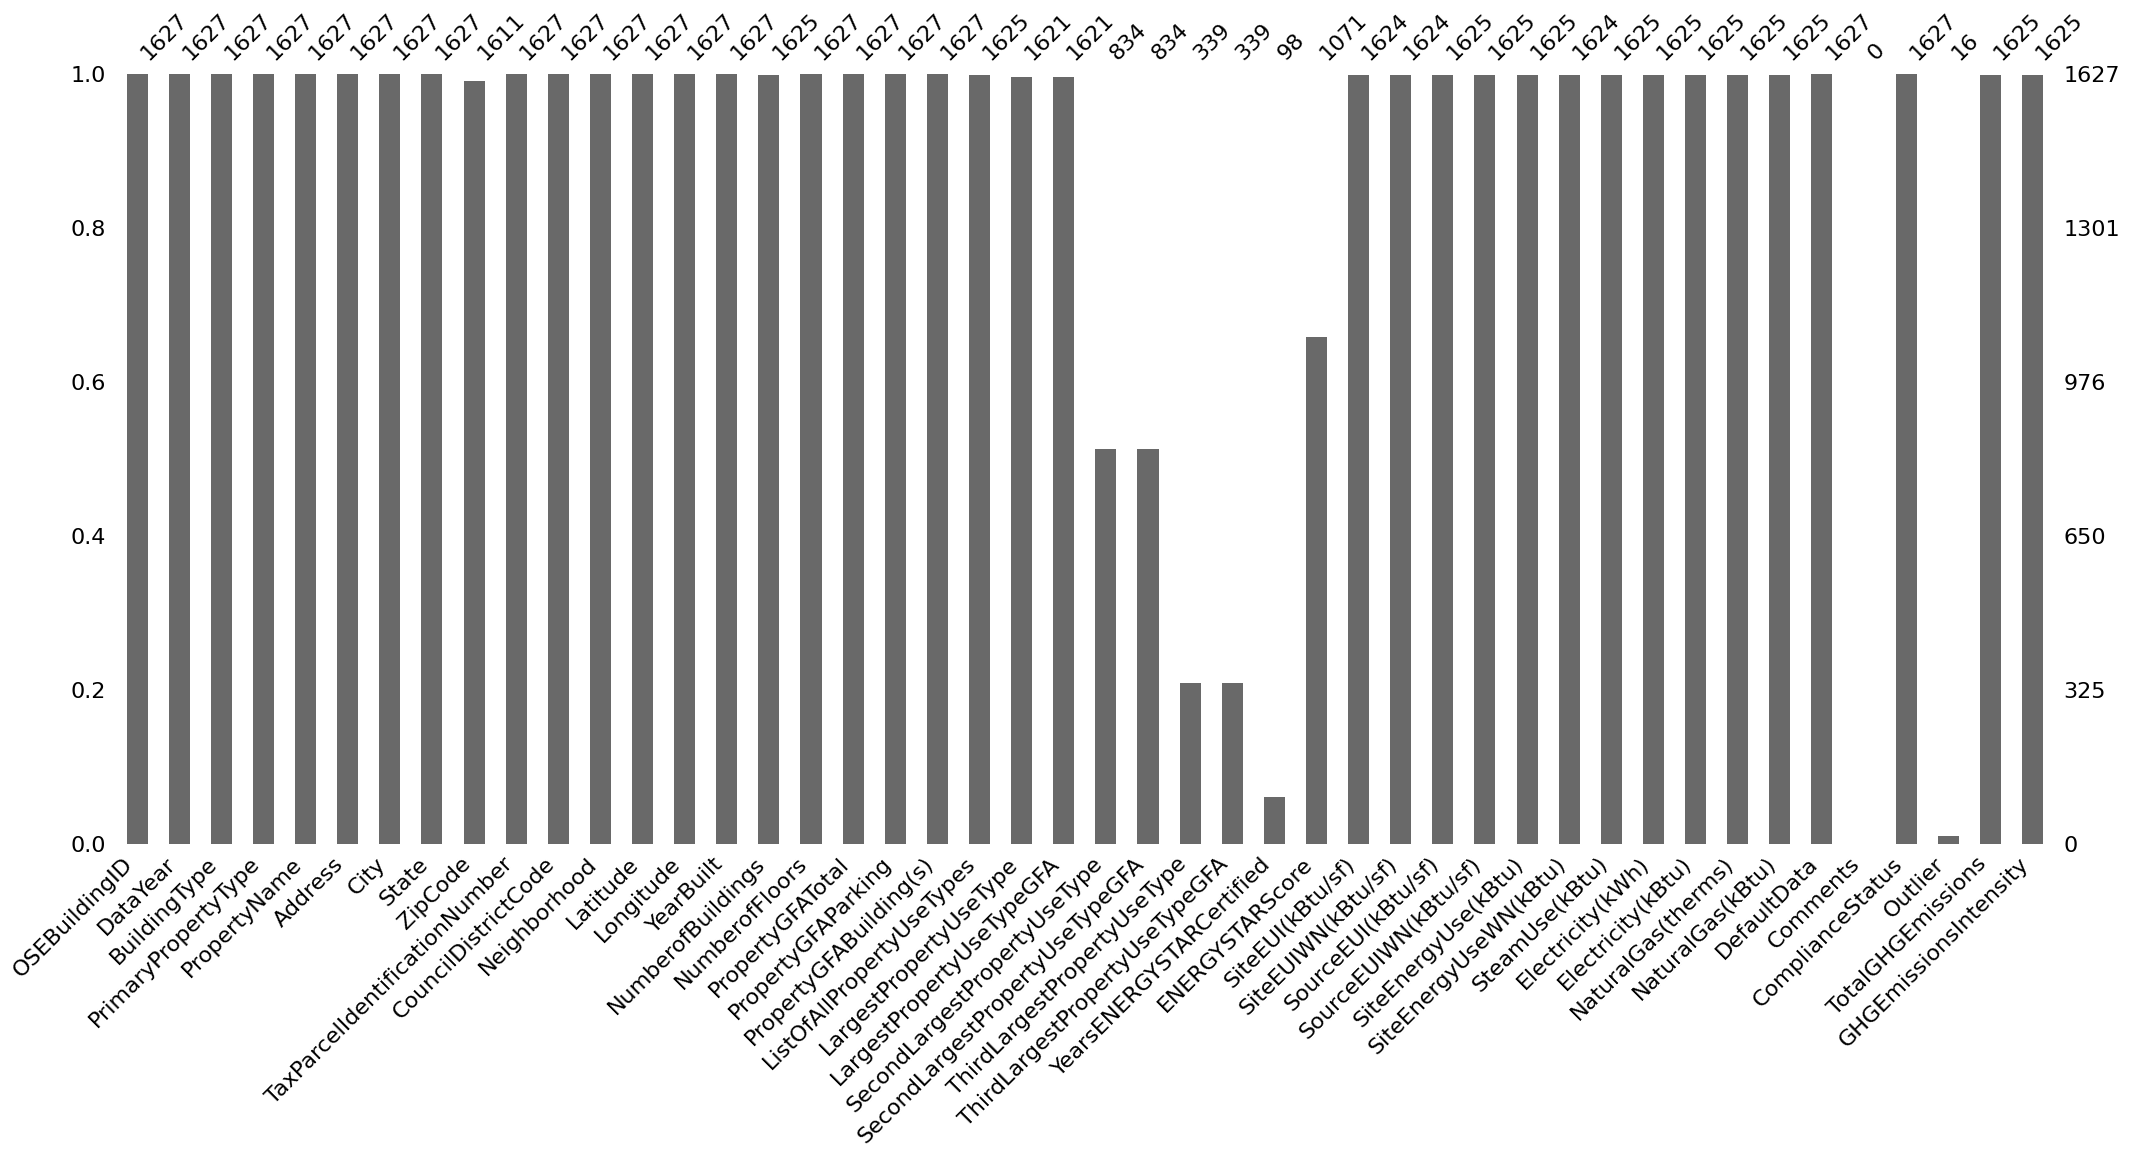

In [383]:
msno.bar(clean_data)

Aucune information n'est disponible concernant le nature de la colonne 'DefaultData', et la colonne 'Comments' ne contient que des nan. On les enlève donc du dataset. 

In [384]:
clean_data.drop(['Comments','DefaultData'],axis = 1, inplace=True)

In [385]:
clean_data.shape

(1627, 44)

## Colonnes "Compliance Status" et "Outlier"

In [386]:
clean_data['ComplianceStatus'].unique()
clean_data['Outlier'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

array([nan, 'High outlier', 'Low outlier'], dtype=object)

In [387]:
len(clean_data.loc[(clean_data['ComplianceStatus'] != 'Compliant')|(~clean_data['Outlier'].isnull())])/len(clean_data)*100

7.314074984634296

Vu le faible pourcentage de propriétés concernées et la quantité de données restante, on se contente tout simplement d'enlever les propriétés qui ont un statut qui n'est pas "Compliant" i.e. qui contient des erreurs ou des données manquantes; ou qui sont des outliers. Cette méthode est préférée à l'imputation des valeurs manquantes car elle évite d'introduire de potentielles erreurs supplémentaires dans les données tout en gardant une quantité de données suffisante pour l'entrainement d'un modèle.

In [388]:
clean_data = clean_data.loc[((clean_data['ComplianceStatus'] == 'Compliant')|(clean_data['Outlier'].isnull()))]
clean_data.shape

(1611, 44)

## Surface

La notion de surface est impliquée dans notamment 3 variables : 'PropertyGFATotal', 'PropertyGFAParking' et 'PropertyGFABuilding(s)'. <br>
GFA = gross floor area. La surface est données en <i> feet square</i>. <br>

Total = Parking + Building(s) : 

In [389]:
(clean_data['PropertyGFATotal'] == (clean_data['PropertyGFAParking'] + clean_data['PropertyGFABuilding(s)'])).sum() == len(clean_data)

np.True_

Ce qui nous intéresse, pour des prédictions de consommation d'énergie et d'émissions de GES, c'est 'PropertyGFABuilding(s)' car les parkings de sont pas chauffés. <br> 
On a aussi l'usage des plus grands batiments de la propriété auxquels sont associés des surfaces.  

In [390]:
clean_data[['PropertyGFABuilding(s)','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']].describe()

,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
count,1.611000e+03,1.605000e+03,828.000000,337.000000
mean,1.070507e+05,1.002438e+05,37115.596977,14737.965575
std,2.881464e+05,2.812351e+05,70235.178530,36970.118388
min,3.636000e+03,5.656000e+03,0.000000,0.000000
25%,2.859300e+04,2.582800e+04,5291.000000,2575.000000
50%,4.769900e+04,4.443100e+04,12000.000000,5713.000000
75%,9.492400e+04,9.243700e+04,31935.750000,12359.000000
max,9.320156e+06,9.320156e+06,686750.000000,459748.000000


In [391]:
clean_data[['PropertyGFABuilding(s)','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']].isnull().sum()

PropertyGFABuilding(s)                0
LargestPropertyUseTypeGFA             6
SecondLargestPropertyUseTypeGFA     783
ThirdLargestPropertyUseTypeGFA     1274
dtype: int64

<Axes: xlabel='PropertyGFABuilding(s)', ylabel='Count'>

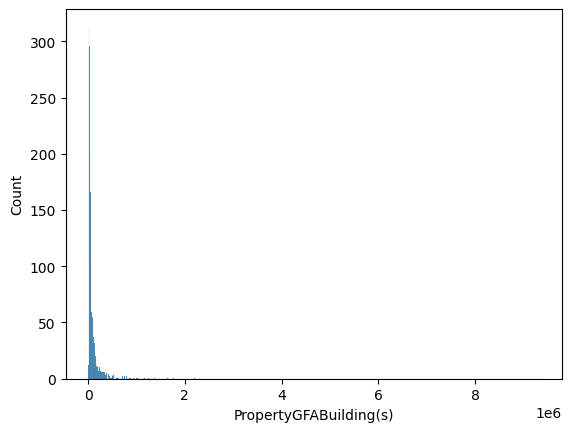

In [392]:
sns.histplot(clean_data['PropertyGFABuilding(s)'])

Il n'y a pas de NaN, les valeurs manquantes signifient simplement qu'il s'agit de propriétés qui n'ont qu'un seul batiment. Il n'y a pas non plus de valeurs nulles ou autres valeurs abbérentes. Il est toutefois difficile de repérer des outliers car on n'a pas de vérité terrain sur lesquelles s'appuyer.

## Consommation d'énergie

- 'SiteEnergyUse(kBtu)' : C'est la consommation d'énergie (en milliers de British termal units) pour l'ensemble des batiments de la propriété. C'est normalement la somme de la consommation d'énergie des différents moyens (electriques, steam et gaz)
- 'SiteEnergyUseWN(kBtu)' est la consommation d'énergie totale mais rectifiée par rapport à la météo du lieu. Cela permet de comparer des batiments qui sont affectés par des conditions climatiques différentes. 
- 'SourceEUI(kBtu/sf)' et 'SourceEUIWN(kBtu/sf)' tiennent compte de l'énergie perdue lors de sa production et de son transport et donnent une valeur par unité de surface.

In [393]:
np.sum((clean_data['SiteEnergyUse(kBtu)'] - (clean_data['NaturalGas(kBtu)'] + clean_data['Electricity(kBtu)'] + clean_data['SteamUse(kBtu)']))/clean_data['SiteEnergyUse(kBtu)']*100 < 5)
clean_data.shape

np.int64(1588)

(1611, 44)

Il y a très peu de propriétés pour lesquelles l'énergie totale utilisée sur site correspond à la somme des énergies utilisées pour le gaz, la vapeur et l'électricité. Pour 1546 propriétés sur 1561, il y a une érreur inférieure à 5%. Ceci signifie soit qu'une source d'énergie n'est pas indiquée dans le tableau (comme l'énergie solaire etc...) soit qu'il y a des valeurs erronées dues par exemple à l'oubli de la prise en compte d'un batiment pour certaines variables et pas pour d'autres. Dans tous les cas, il vaut mieux ne rien changer.

In [394]:
clean_data['SiteEnergyUseWN(kBtu)'].describe()

count    1.608000e+03
mean     8.189229e+06
std      2.237103e+07
min      0.000000e+00
25%      1.308032e+06
50%      2.736046e+06
75%      7.250945e+06
max      4.716139e+08
Name: SiteEnergyUseWN(kBtu), dtype: float64

In [395]:
clean_data.loc[clean_data['SiteEnergyUseWN(kBtu)'] == 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
28,34,2016,SPS-District K-12,K-12 School,Meany Building,301/300 21st Ave. E.,Seattle,WA,98112.0,0688000090,3,Central,47.62266,-122.30547,1955,1.0,1,126351,0,126351,K-12 School,K-12 School,126351.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,0.000000,0.0,Missing Data,NaN,0.00,0.00
31,37,2016,SPS-District K-12,K-12 School,John Hay Elementary,201 Garfield St.,Seattle,WA,98109.0,0809000005,7,MAGNOLIA / QUEEN ANNE,47.63290,-122.35172,1989,1.0,2,51582,0,51582,K-12 School,K-12 School,55166.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.00,4.386917e+05,1496816.0,0.000000,0.0,Missing Data,NaN,10.43,0.20
62,87,2016,SPS-District K-12,K-12 School,Arbor Heights Elementary,3701 S.W. 104th St.,Seattle,WA,98146.0,2518400005,1,SOUTHWEST,47.50970,-122.37759,1948,1.0,2,53352,0,53352,K-12 School,K-12 School,65568.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.00,1.760881e+05,600813.0,0.000000,0.0,Missing Data,NaN,4.19,0.08
81,118,2016,SPS-District K-12,K-12 School,Pathfinder K-8,1901 SW Genesee St.,Seattle,WA,98106.0,1324039116,1,DELRIDGE,47.56360,-122.35800,1999,1.0,3,74468,0,74468,K-12 School,K-12 School,75364.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.00,4.977068e+05,1698176.0,0.000000,0.0,Missing Data,NaN,11.84,0.16
85,122,2016,SPS-District K-12,K-12 School,John Muir Elementary,3301 S. Horton St.,Seattle,WA,98144.0,1524049002,2,SOUTHEAST,47.57324,-122.29058,1991,1.0,2,58933,0,58933,K-12 School,K-12 School,60725.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.00,6.879069e+05,2347138.0,0.000000,0.0,Missing Data,NaN,16.36,0.28
95,140,2016,SPS-District K-12,K-12 School,B.F. Day Elementary,3921 Linden Ave. N.,Seattle,WA,98103.0,1931301145,6,LAKE UNION,47.65464,-122.34912,1991,1.0,3,66588,0,66588,K-12 School,K-12 School,66588.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.00,6.167308e+05,2104286.0,0.000000,0.0,Missing Data,NaN,14.67,0.22
133,217,2016,SPS-District K-12,K-12 School,Whitman Middle,9201 15th Ave. NW.,Seattle,WA,98117.0,3526039131,6,BALLARD,47.69675,-122.37760,1959,1.0,1,160270,0,160270,K-12 School,K-12 School,160270.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,43189.171880,4318917.0,Missing Data,NaN,229.38,1.43
139,227,2016,SPS-District K-12,K-12 School,Washington Middle,2101 S. Jackson,Seattle,WA,98144.0,3646100540,3,CENTRAL,47.59796,-122.30415,1963,1.0,3,136188,0,136188,K-12 School,K-12 School,136188.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,32178.773440,3217877.0,Missing Data,NaN,170.90,1.25
152,242,2016,SPS-District K-12,K-12 School,Olympic View Elementary,504 N.E. 95th St.,Seattle,WA,98115.0,5100404840,5,NORTH,47.69823,-122.32126,1989,1.0,2,52792,0,52792,K-12 School,K-12 School,55480.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.00,0.000000e+00,0.0,0.000000,0.0,Missing Data,NaN,0.00,0.00
220,343,2016,NonResidential,Large Office,Norton Building,801 2nd Ave Suite 1300,Seattle,WA,98104.0,0939000355,7,DOWNTOWN,47.60370,-122.33447,1958,1.0,17,378525,84600,293925,"Office, Parking",Of

Les propriétés pour lesquelles la consommation d'énergie est nulle sont des valeurs aberrantes. On retire ces propriétés du dataset pour éviter d'introduire du bruit et parce qu'il restera suffisamment de données. Il est cependant important de noter qu'il s'agit pour la plupart d'infrastructures scolaires mais il restera encore des propriétés entrant dans cette catégorie compte tenu du nombre total : 

In [396]:
len(clean_data.loc[clean_data['BuildingType'] == 'SPS-District K-12'])

97

In [397]:
clean_data = clean_data.loc[clean_data['SiteEnergyUseWN(kBtu)'] > 0]

<Axes: xlabel='SiteEnergyUseWN(kBtu)', ylabel='Count'>

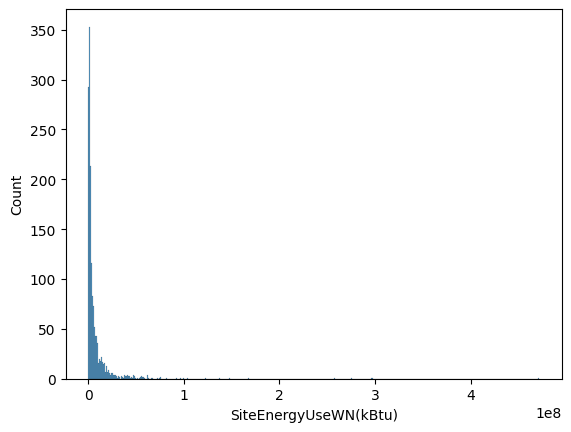

In [398]:
sns.histplot(clean_data['SiteEnergyUseWN(kBtu)'])

## Emissions de gaz à effet de serre

- 'TotalGHGEmissions' : GHG = greenhousegas. Exprimé en tonnes d'équivalent C02.
- 'GHGEmissionsIntensity' : émissions de gaz à affet de serre en kilogrammes d'équivalent carbone par square foot.
- L'émission de GES est dépendante de la consommation énergétique

In [399]:
clean_data['TotalGHGEmissions'].describe()

count     1583.000000
mean       183.128048
std        719.561390
min         -0.800000
25%         20.760000
50%         49.980000
75%        144.600000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

In [400]:
clean_data.loc[clean_data['TotalGHGEmissions'] <= 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
513,700,2016,NonResidential,Supermarket / Grocery Store,IUC- Whole Foods Interbay,2001 15th Avenue West,Seattle,WA,98119.0,7666201460,7,MAGNOLIA / QUEEN ANNE,47.63718,-122.37734,2008,1.0,1,57176,0,57176,"Personal Services (Health/Beauty, Dry Cleaning, etc), Retail Store, Supermarket/Grocery Store",Supermarket/Grocery Store,39500.0,Retail Store,15000.0,"Personal Services (Health/Beauty, Dry Cleaning, etc)",5500.0,NaN,31.0,208.800003,214.100006,0.0,0.0,1.252517e+07,1.284386e+07,0.0,0.00000,0.0,0.0,0.0,Compliant,NaN,0.0,0.00
3206,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,1501 E. Madison St.,Seattle,WA,98122.0,7234600195,3,CENTRAL,47.61432,-122.31257,2013,1.0,6,52000,0,52000,Office,Office,48159.0,NaN,NaN,NaN,NaN,NaN,100.0,7.100000,5.000000,2.0,-2.1,3.427261e+05,2.401321e+05,0.0,-33826.80078,-115417.0,0.0,0.0,Compliant,NaN,-0.8,-0.02


Les propriétés pour lesquelles l'émission de GES est négative ou nulle sont des valeurs aberrantes. On retire ces propriétés du dataset.

In [401]:
clean_data = clean_data.loc[clean_data['TotalGHGEmissions'] > 0]

<Axes: xlabel='TotalGHGEmissions', ylabel='Count'>

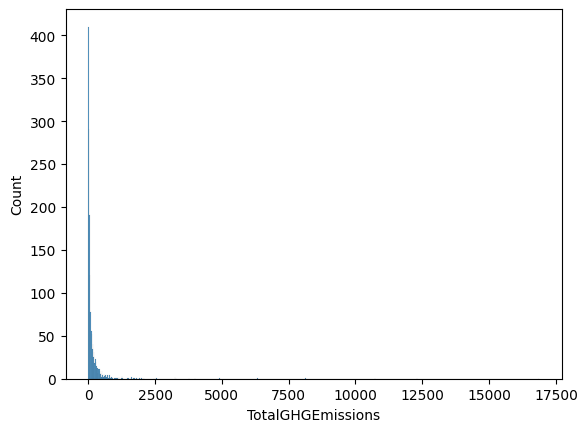

In [402]:
sns.histplot(clean_data['TotalGHGEmissions'])

## Année de construction

<Axes: xlabel='YearBuilt', ylabel='Count'>

Text(1934.0, 40, 'Great \n Depression')

Text(1952.5, 40, 'Post-WWII \n Boom')

Text(1976.5, 40, 'Oil \n Crisis')

Text(2009.0, 40, 'Financial \n Crisis')

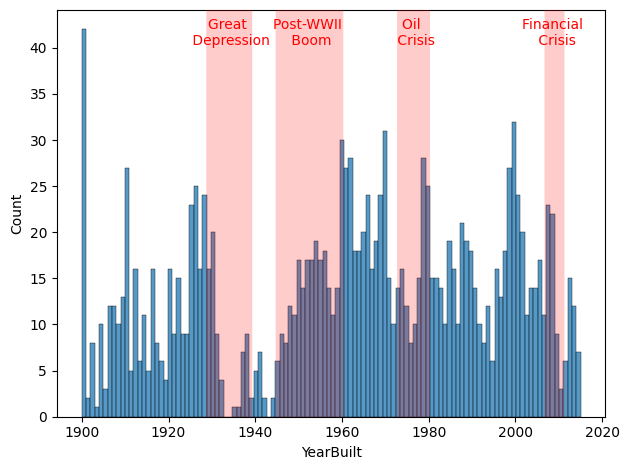

In [403]:
sns.histplot(clean_data['YearBuilt'], bins = 116)
crises = [
    {"start_year": 1929, "end_year": 1939, "name": "Great \n Depression"},
    {"start_year": 1945, "end_year": 1960, "name": "Post-WWII \n Boom"},
    {"start_year": 1973, "end_year": 1980, "name": "Oil \n Crisis"},
    {"start_year": 2007, "end_year": 2011, "name": "Financial \n Crisis"}
]
for crisis in crises:
    # Create a rectangle for the period of the crisis
    rect = patches.FancyBboxPatch((crisis["start_year"], 0),  # (x, y) bottom-left corner
                                  crisis["end_year"] - crisis["start_year"],  # width of the rectangle
                                  100,  # height of the rectangle (adjust this as needed)
                                  linewidth=0,  # no border
                                  facecolor='red',  # color of the rectangle
                                  alpha=0.2,  # transparency of the rectangle
                                  zorder=5)
    
    # Add the rectangle to the plot
    plt.gca().add_patch(rect)
    
    # Annotate the crisis with centered text at the midpoint of the period
    midpoint = (crisis["start_year"] + crisis["end_year"]) / 2
    plt.text(midpoint, 40,  # Midpoint for positioning the text
             crisis["name"],  # Text label for the crisis
             color='red', fontsize=10, verticalalignment='bottom', horizontalalignment='center')

# Show the plot
plt.tight_layout()
plt.show()


## Quartiers de la ville

In [404]:
clean_data['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'NORTH',
       'LAKE UNION', 'GREATER DUWAMISH', 'MAGNOLIA / QUEEN ANNE',
       'BALLARD', 'NORTHWEST', 'CENTRAL', 'SOUTHWEST', 'Ballard',
       'DELRIDGE', 'North', 'Delridge', 'Northwest', 'Central',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

Il y a des doublons à cause d'erreurs de format : minuscules / majuscules

In [405]:
clean_data['Neighborhood'] = clean_data['Neighborhood'].str.upper()
clean_data['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'NORTH',
       'LAKE UNION', 'GREATER DUWAMISH', 'MAGNOLIA / QUEEN ANNE',
       'BALLARD', 'NORTHWEST', 'CENTRAL', 'SOUTHWEST', 'DELRIDGE',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

On fusionne DELRIDGE et DELRIDGE NEIGHBOURHOODS en DELRIDGE.

In [406]:
clean_data.loc[clean_data['Neighborhood'] == 'DELRIDGE NEIGHBORHOODS', 'Neighborhood'] = 'DELRIDGE'
clean_data['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'NORTH',
       'LAKE UNION', 'GREATER DUWAMISH', 'MAGNOLIA / QUEEN ANNE',
       'BALLARD', 'NORTHWEST', 'CENTRAL', 'SOUTHWEST', 'DELRIDGE'],
      dtype=object)

On visualise la position des propriétés sur une carte et on leur donne une couleur en fonction de leur étiquête "quartier". 

<Axes: >

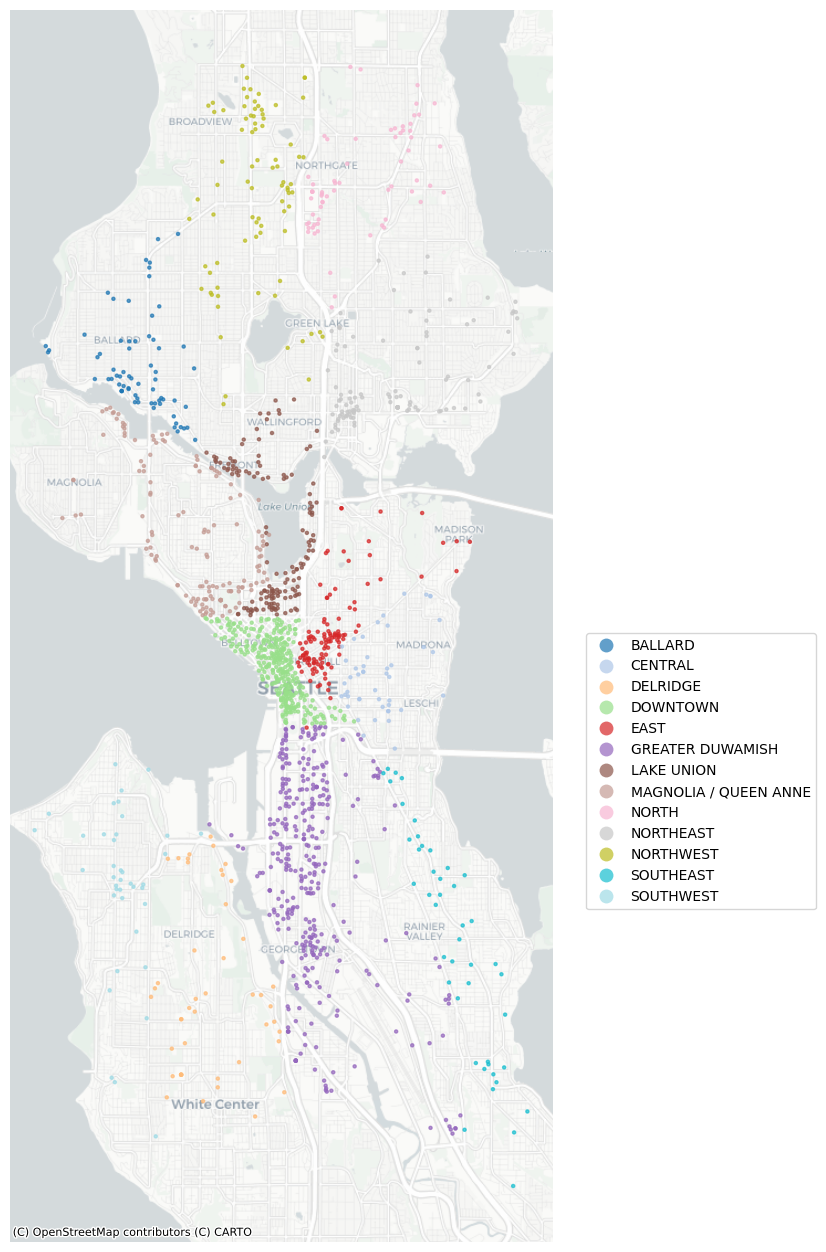

In [407]:
# Convert data to GeoDataFrame
gdf = gpd.GeoDataFrame(
    clean_data, geometry=gpd.points_from_xy(clean_data.Longitude, clean_data.Latitude), crs="EPSG:4326"
)

# Reproject to Web Mercator (needed for Contextily basemap)
gdf = gdf.to_crs(epsg=3857)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 16))

# Plot buildings, coloring by neighbourhood
gdf.plot(
    ax=ax,
    column="Neighborhood",
    cmap="tab20",  # Change color palette if needed
    legend=True,
    alpha=0.7,
    markersize=5
)

# Add a basemap (Seattle real map)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)  # Light-colored map
# Alternative: ctx.providers.Stamen.TonerLite (darker contrast)

# Remove axis labels (optional)
ax.set_axis_off()

# Move legend outside
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.05, 0.5))  # Adjust position (right of the plot)
plt.show()

In [ ]:
#TODO ajouter la variable consommation d'énergie sur la carte.

<Axes: xlabel='Neighborhood', ylabel='count'>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'DOWNTOWN'),
  Text(1, 0, 'GREATER DUWAMISH'),
  Text(2, 0, 'LAKE UNION'),
  Text(3, 0, 'MAGNOLIA / QUEEN ANNE'),
  Text(4, 0, 'EAST'),
  Text(5, 0, 'NORTHEAST'),
  Text(6, 0, 'NORTHWEST'),
  Text(7, 0, 'BALLARD'),
  Text(8, 0, 'NORTH'),
  Text(9, 0, 'CENTRAL'),
  Text(10, 0, 'DELRIDGE'),
  Text(11, 0, 'SOUTHEAST'),
  Text(12, 0, 'SOUTHWEST')])

Text(0, 0.5, '%')

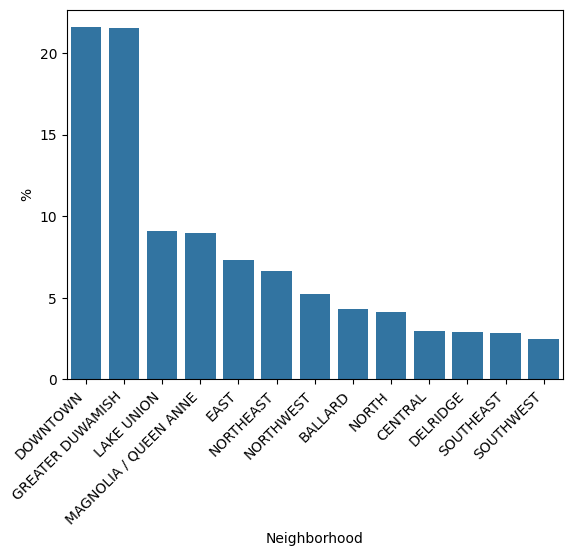

In [408]:
sns.barplot(clean_data['Neighborhood'].value_counts()/len(clean_data)*100)
# Rotate x-axis labels
plt.xticks(rotation=45, ha = 'right')  # Adjust angle as needed
plt.ylabel('%')
plt.show()

DOWNTOWN et GREATER DUWAMISH sont largement sur-représentés dans les données puisqu'ils représentent à eux deux près de la moitié des propriétés référencées dans ce dataset. Il sagit surement de quartiers d'affaire et commerciaux. Mais s'il s'agit d'un biais de référencement, cela pourrait créer un biais dans les réponses des modèles qui sera du coup entraité sur une majorité de données provenant de ces deux quartiers. Mais cette variable a-t-elle un impact sur les variables cibles ?

<Axes: xlabel='Neighborhood', ylabel='SiteEUIWN(kBtu/sf)'>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'DOWNTOWN'),
  Text(1, 0, 'SOUTHEAST'),
  Text(2, 0, 'NORTHEAST'),
  Text(3, 0, 'EAST'),
  Text(4, 0, 'NORTH'),
  Text(5, 0, 'LAKE UNION'),
  Text(6, 0, 'GREATER DUWAMISH'),
  Text(7, 0, 'MAGNOLIA / QUEEN ANNE'),
  Text(8, 0, 'BALLARD'),
  Text(9, 0, 'NORTHWEST'),
  Text(10, 0, 'CENTRAL'),
  Text(11, 0, 'SOUTHWEST'),
  Text(12, 0, 'DELRIDGE')])

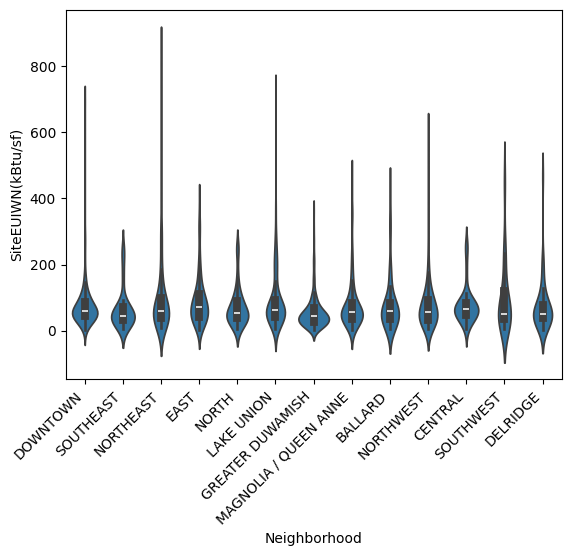

In [409]:
sns.violinplot(data = clean_data, x = 'Neighborhood', y='SiteEUIWN(kBtu/sf)')
plt.xticks(rotation=45, ha = 'right')

In [410]:
# Group the values by category
grouped_data = [clean_data['SiteEUIWN(kBtu/sf)'][clean_data['Neighborhood'] == category] for category in clean_data['Neighborhood'].unique()]

# Perform ANOVA
f_statistic, p_value = stats.f_oneway(*grouped_data)

# Output the result
print(f"F-statistic: {f_statistic}, p-value: {p_value}")

F-statistic: 4.271199308947354, p-value: 1.0980213960741442e-06


<Axes: xlabel='Neighborhood', ylabel='GHGEmissionsIntensity'>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'DOWNTOWN'),
  Text(1, 0, 'SOUTHEAST'),
  Text(2, 0, 'NORTHEAST'),
  Text(3, 0, 'EAST'),
  Text(4, 0, 'NORTH'),
  Text(5, 0, 'LAKE UNION'),
  Text(6, 0, 'GREATER DUWAMISH'),
  Text(7, 0, 'MAGNOLIA / QUEEN ANNE'),
  Text(8, 0, 'BALLARD'),
  Text(9, 0, 'NORTHWEST'),
  Text(10, 0, 'CENTRAL'),
  Text(11, 0, 'SOUTHWEST'),
  Text(12, 0, 'DELRIDGE')])

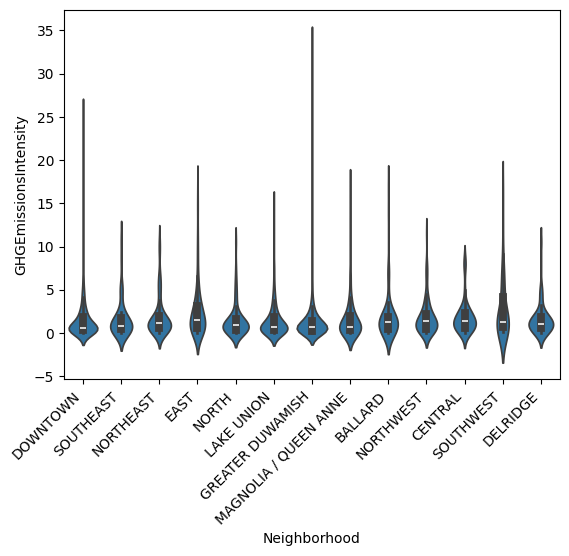

In [411]:
sns.violinplot(data = clean_data, x = 'Neighborhood', y='GHGEmissionsIntensity')
plt.xticks(rotation=45, ha = 'right')

In [412]:
# Group the values by category
grouped_data = [clean_data['GHGEmissionsIntensity'][clean_data['Neighborhood'] == category] for category in clean_data['Neighborhood'].unique()]

# Perform ANOVA
f_statistic, p_value = stats.f_oneway(*grouped_data)

# Output the result
print(f"F-statistic: {f_statistic}, p-value: {p_value}")

F-statistic: 4.149536344601402, p-value: 1.948590885157051e-06


Remarque : ici j'ai pris les variables cibles normalisées par unité de surface pour que la surface n'entre pas en ligne de compte dans la comparaison entre les quartiers. Le résultat des ANOVA montre qu'il y a une différence significative entre les quartiers, et qu'elle n'est pas due à un climat spécifique. 

## Analyse univariée

<Figure size 1000x500 with 0 Axes>

<Axes: >

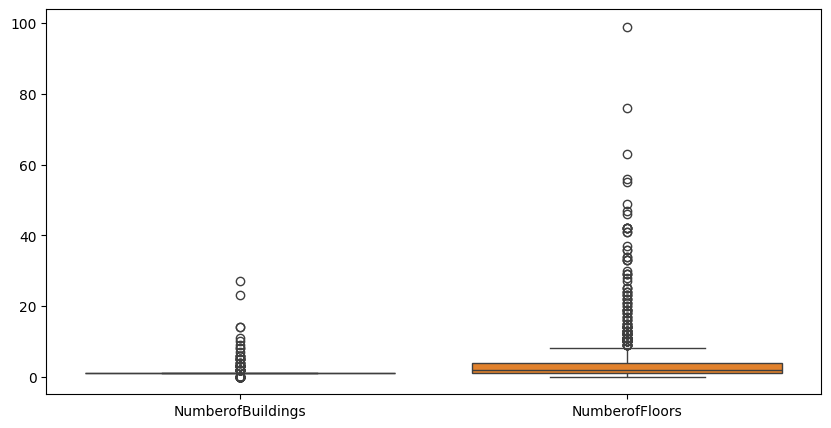

In [413]:
# Select only numeric columns
df_numeric = clean_data.select_dtypes(include=['number'])

#Select columns
columns_to_keep = []
for column in df_numeric.columns:
    if "Numberof" in column:
        columns_to_keep.append(column)

df_numeric = df_numeric[columns_to_keep]

# Convert to long format (for Seaborn)
# df_melted = df_numeric.melt(var_name="Variable", value_name="Value")

# Plot boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_numeric)
# plt.xticks(rotation=45)
# plt.title("Distribution des variables numériques standardisées")
plt.show()

<Figure size 1000x500 with 0 Axes>

<Axes: >

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'PropertyGFATotal'),
  Text(1, 0, 'PropertyGFAParking'),
  Text(2, 0, 'PropertyGFABuilding(s)'),
  Text(3, 0, 'LargestPropertyUseTypeGFA'),
  Text(4, 0, 'SecondLargestPropertyUseTypeGFA'),
  Text(5, 0, 'ThirdLargestPropertyUseTypeGFA')])

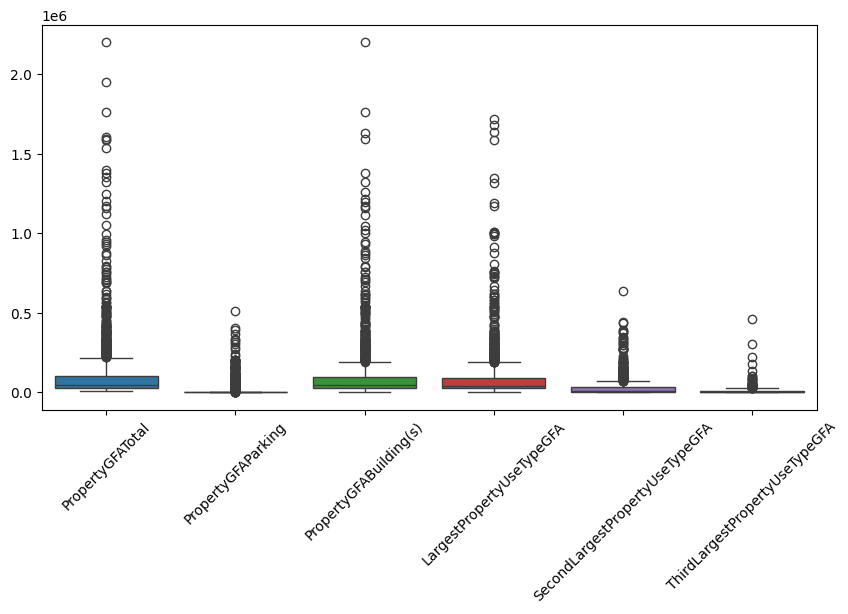

In [414]:
# Select only numeric columns
df_numeric = clean_data.select_dtypes(include=['number'])

#Select columns
columns_to_keep = []
for column in df_numeric.columns:
    if "GFA" in column:
        columns_to_keep.append(column)

df_numeric = df_numeric[columns_to_keep]

# Convert to long format (for Seaborn)
# df_melted = df_numeric.melt(var_name="Variable", value_name="Value")

# Plot boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_numeric)
plt.xticks(rotation=45)
# plt.title("Distribution des variables numériques standardisées")
plt.show()

<Figure size 1000x500 with 0 Axes>

<Axes: >

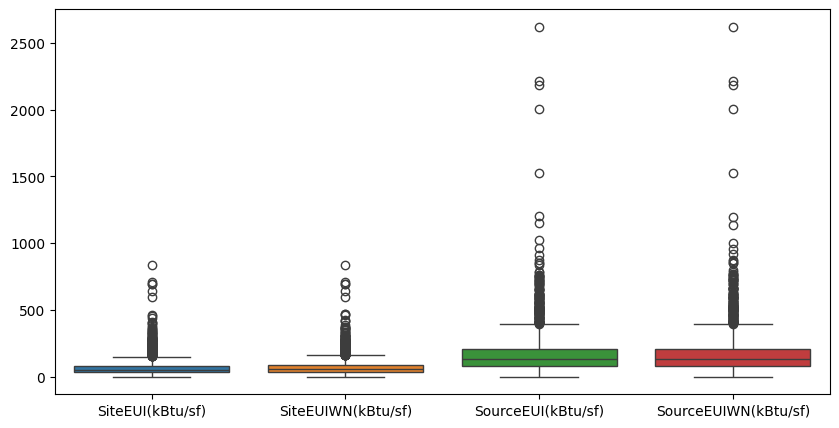

In [415]:
# Select only numeric columns
df_numeric = clean_data.select_dtypes(include=['number'])

#Select columns
columns_to_keep = []
for column in df_numeric.columns:
    if "(kBtu/sf)" in column:
        columns_to_keep.append(column)

df_numeric = df_numeric[columns_to_keep]

# Convert to long format (for Seaborn)
# df_melted = df_numeric.melt(var_name="Variable", value_name="Value")

# Plot boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_numeric)
# plt.xticks(rotation=45)
# plt.title("Distribution des variables numériques standardisées")
plt.show()

<Figure size 1000x500 with 0 Axes>

<Axes: >

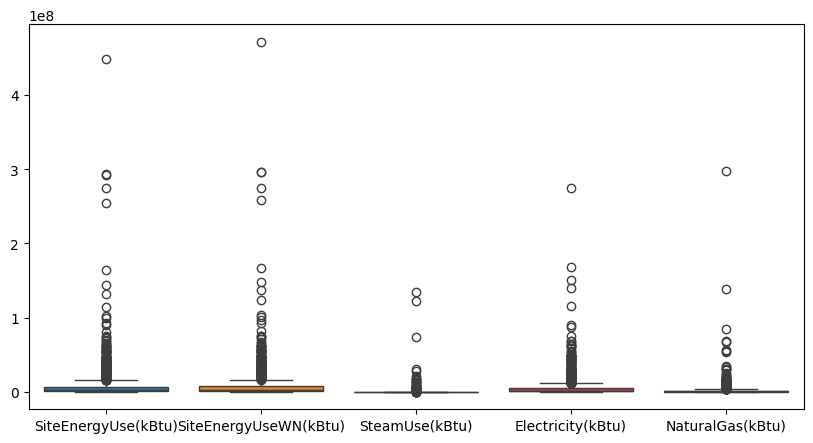

In [416]:
# Select only numeric columns
df_numeric = clean_data.select_dtypes(include=['number'])

#Select columns
columns_to_keep = []
for column in df_numeric.columns:
    if "(kBtu)" in column:
        columns_to_keep.append(column)

df_numeric = df_numeric[columns_to_keep]

# Convert to long format (for Seaborn)
# df_melted = df_numeric.melt(var_name="Variable", value_name="Value")

# Plot boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_numeric)
# plt.xticks(rotation=45)
# plt.title("Distribution des variables numériques standardisées")
plt.show()

## Analyse bivariée

Matrice de corrélation

([<matplotlib.axis.XTick at 0x7f08369b8cd0>,
 [Text(0, 0, 'OSEBuildingID'),
  Text(1, 0, 'DataYear'),
  Text(2, 0, 'ZipCode'),
  Text(3, 0, 'CouncilDistrictCode'),
  Text(4, 0, 'Latitude'),
  Text(5, 0, 'Longitude'),
  Text(6, 0, 'YearBuilt'),
  Text(7, 0, 'NumberofBuildings'),
  Text(8, 0, 'NumberofFloors'),
  Text(9, 0, 'PropertyGFATotal'),
  Text(10, 0, 'PropertyGFAParking'),
  Text(11, 0, 'PropertyGFABuilding(s)'),
  Text(12, 0, 'LargestPropertyUseTypeGFA'),
  Text(13, 0, 'SecondLargestPropertyUseTypeGFA'),
  Text(14, 0, 'ThirdLargestPropertyUseTypeGFA'),
  Text(15, 0, 'ENERGYSTARScore'),
  Text(16, 0, 'SiteEUI(kBtu/sf)'),
  Text(17, 0, 'SiteEUIWN(kBtu/sf)'),
  Text(18, 0, 'SourceEUI(kBtu/sf)'),
  Text(19, 0, 'SourceEUIWN(kBtu/sf)'),
  Text(20, 0, 'SiteEnergyUse(kBtu)'),
  Text(21, 0, 'SiteEnergyUseWN(kBtu)'),
  Text(22, 0, 'SteamUse(kBtu)'),
  Text(23, 0, 'Electricity(kWh)'),
  Text(24, 0, 'Electricity(kBtu)'),
  Text(25, 0, 'NaturalGas(therms)'),
  Text(26, 0, 'NaturalGas(kBtu)')

([<matplotlib.axis.YTick at 0x7f08369b9450>,
 [Text(0, 0, 'OSEBuildingID'),
  Text(0, 1, 'DataYear'),
  Text(0, 2, 'ZipCode'),
  Text(0, 3, 'CouncilDistrictCode'),
  Text(0, 4, 'Latitude'),
  Text(0, 5, 'Longitude'),
  Text(0, 6, 'YearBuilt'),
  Text(0, 7, 'NumberofBuildings'),
  Text(0, 8, 'NumberofFloors'),
  Text(0, 9, 'PropertyGFATotal'),
  Text(0, 10, 'PropertyGFAParking'),
  Text(0, 11, 'PropertyGFABuilding(s)'),
  Text(0, 12, 'LargestPropertyUseTypeGFA'),
  Text(0, 13, 'SecondLargestPropertyUseTypeGFA'),
  Text(0, 14, 'ThirdLargestPropertyUseTypeGFA'),
  Text(0, 15, 'ENERGYSTARScore'),
  Text(0, 16, 'SiteEUI(kBtu/sf)'),
  Text(0, 17, 'SiteEUIWN(kBtu/sf)'),
  Text(0, 18, 'SourceEUI(kBtu/sf)'),
  Text(0, 19, 'SourceEUIWN(kBtu/sf)'),
  Text(0, 20, 'SiteEnergyUse(kBtu)'),
  Text(0, 21, 'SiteEnergyUseWN(kBtu)'),
  Text(0, 22, 'SteamUse(kBtu)'),
  Text(0, 23, 'Electricity(kWh)'),
  Text(0, 24, 'Electricity(kBtu)'),
  Text(0, 25, 'NaturalGas(therms)'),
  Text(0, 26, 'NaturalGas(kBtu)')

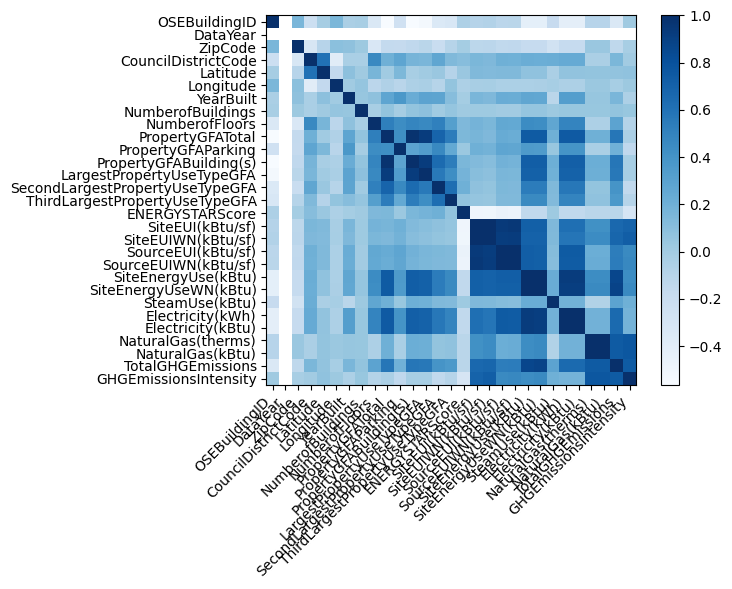

In [417]:
matrix = clean_data.corr(method = 'spearman', numeric_only = True)

# plotting correlation matrix
plt.imshow(matrix, cmap='Blues')

# adding colorbar
plt.colorbar()

# extracting variable names
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Display the plot
plt.show()

# II - Sélection des variables et séparation des données en train et test

La première variable cible qui nous intéresse est la consommation d'énergie totale, normalisé par rapport aux données météo. Dans le dataset, il s'agit de la colonne SiteEnergyUseWN <br> 
Pour la prédire, on va utiliser les variables qui paraissent, d'un point de vue métier et des corrélations calculées ci-dessus, en lien avec elle : 
- NumberofBuildings
- NumberofFloors
- PropertyGFABuilding(s)
- LargestPropertyUseTypeGFA
- SecondLargestPropertyUseTypeGFA
- ThirdLargestPropertyUseTypeGFA

Nous disposons aussi de variables catégorielles potentiellement intéressantes : 
- PrimaryPropertyType
- LargestPropertyUseType
- SecondLargestPropertyUseType
- ThirdLargestPropertyUseType
- Neighborhood

In [418]:
data_selected = clean_data[['NumberofBuildings','NumberofFloors','YearBuilt','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                          'ThirdLargestPropertyUseTypeGFA','PrimaryPropertyType','LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType',
                          'Neighborhood', 'SiteEnergyUseWN(kBtu)','TotalGHGEmissions']] 

<Axes: >

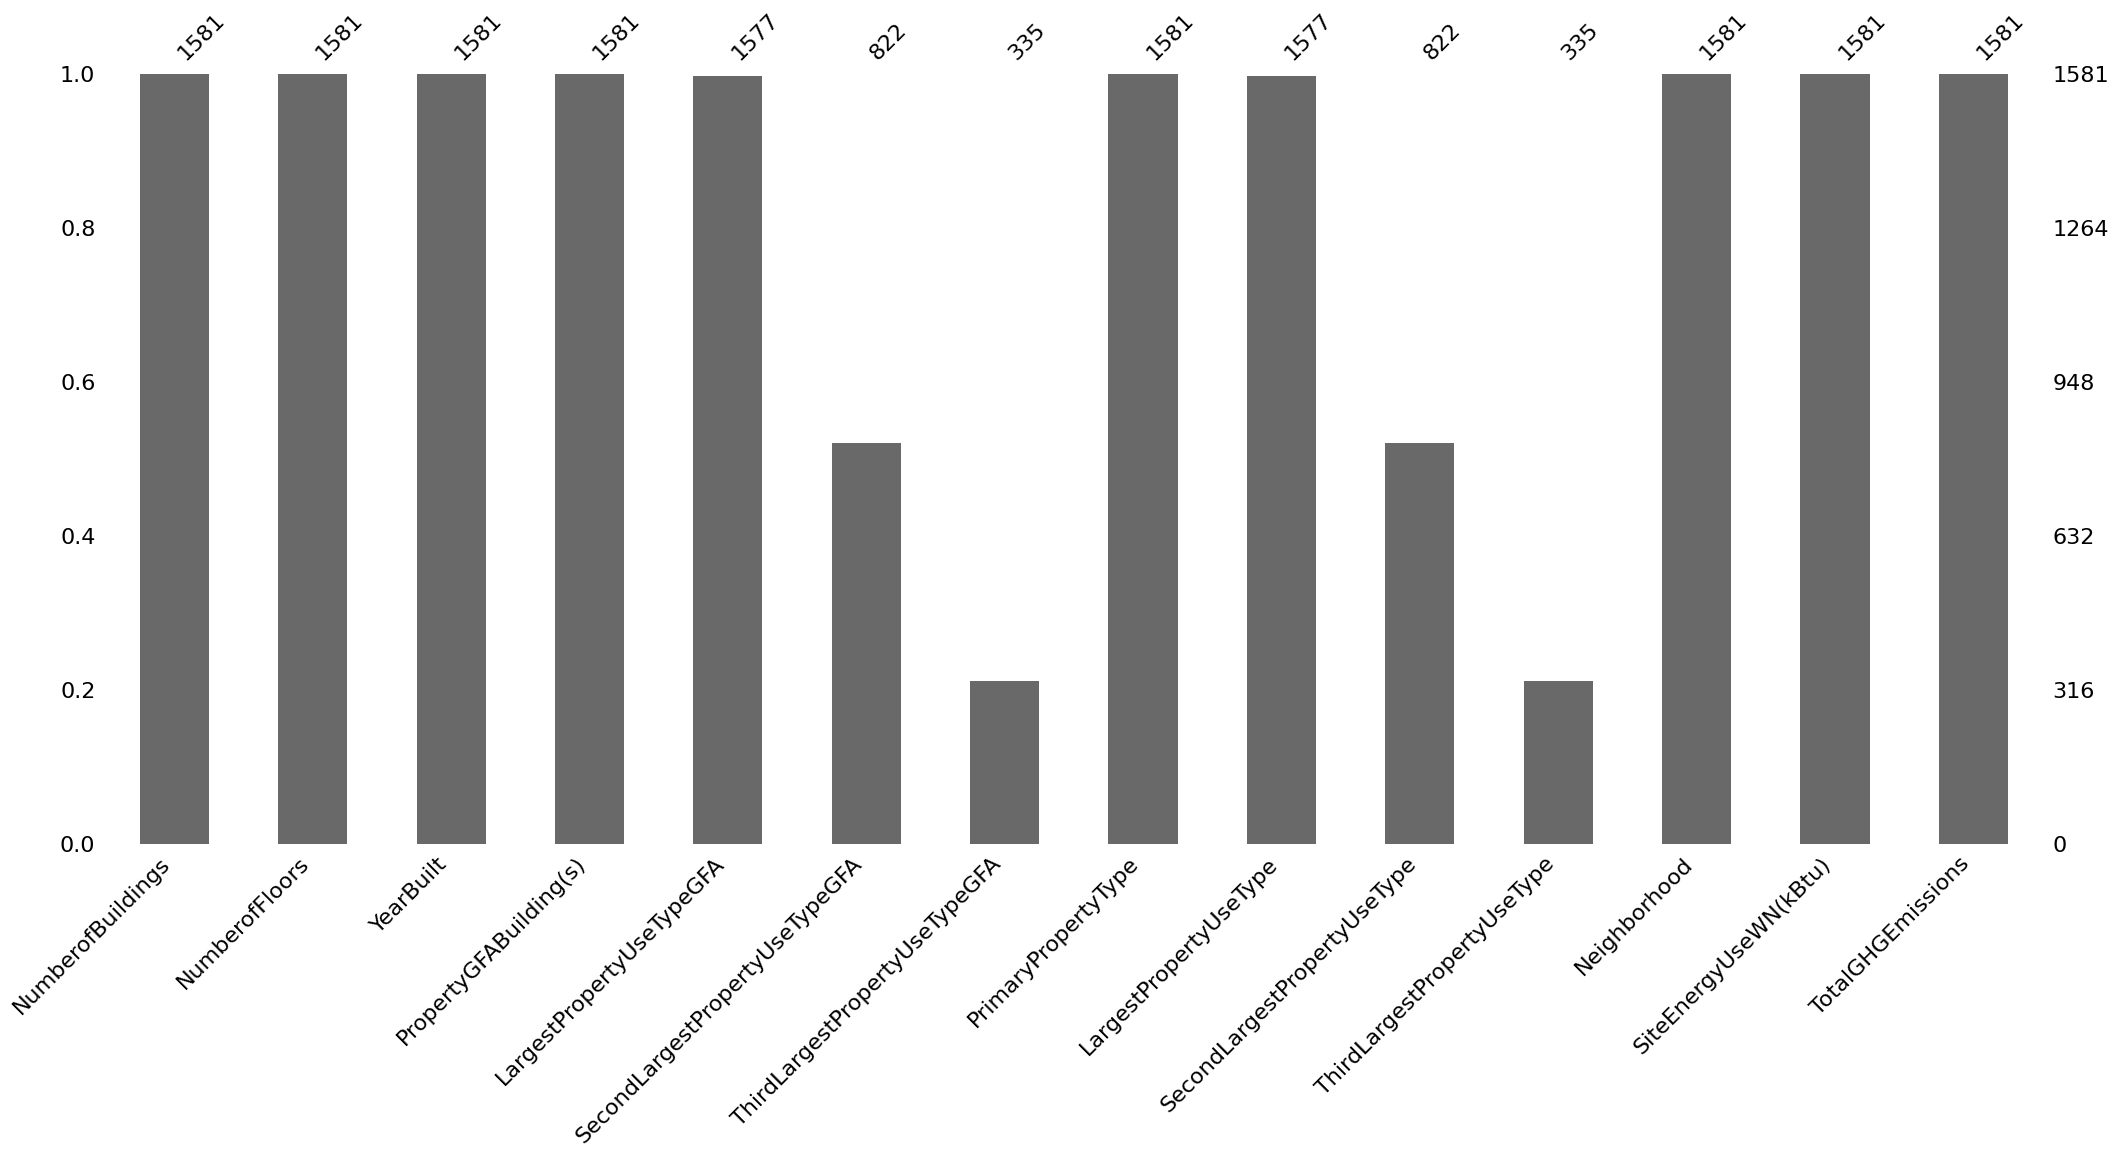

In [419]:
msno.bar(data_selected)

On enlève les propriétés qui n'ont pas de valeur cible et qui ont des nan dans leurs variables explicatives. Toutes les propriétés n'ont pas plusieurs batiments donc ne peuvent pas toutes avoir de valeurs dans les colonnes du type 'SecondLargest' et 'ThirdLargest'. Il ne s'agit donc pas de réelles valeurs manquantes donc les remplace par 0 ou 'Inexistant' en fonction tu type de variable

In [420]:
data_selected.loc[data_selected['SecondLargestPropertyUseTypeGFA'].isnull(),'SecondLargestPropertyUseTypeGFA'] = 0
data_selected.loc[data_selected['ThirdLargestPropertyUseTypeGFA'].isnull(),'ThirdLargestPropertyUseTypeGFA'] = 0

data_selected.loc[data_selected['SecondLargestPropertyUseType'].isnull(),'SecondLargestPropertyUseType'] = 'none'
data_selected.loc[data_selected['ThirdLargestPropertyUseType'].isnull(),'ThirdLargestPropertyUseType'] = 'none'

In [421]:
data_selected.dropna(inplace = True)

/tmp/ipykernel_64200/2137253860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.dropna(inplace = True)


<Axes: >

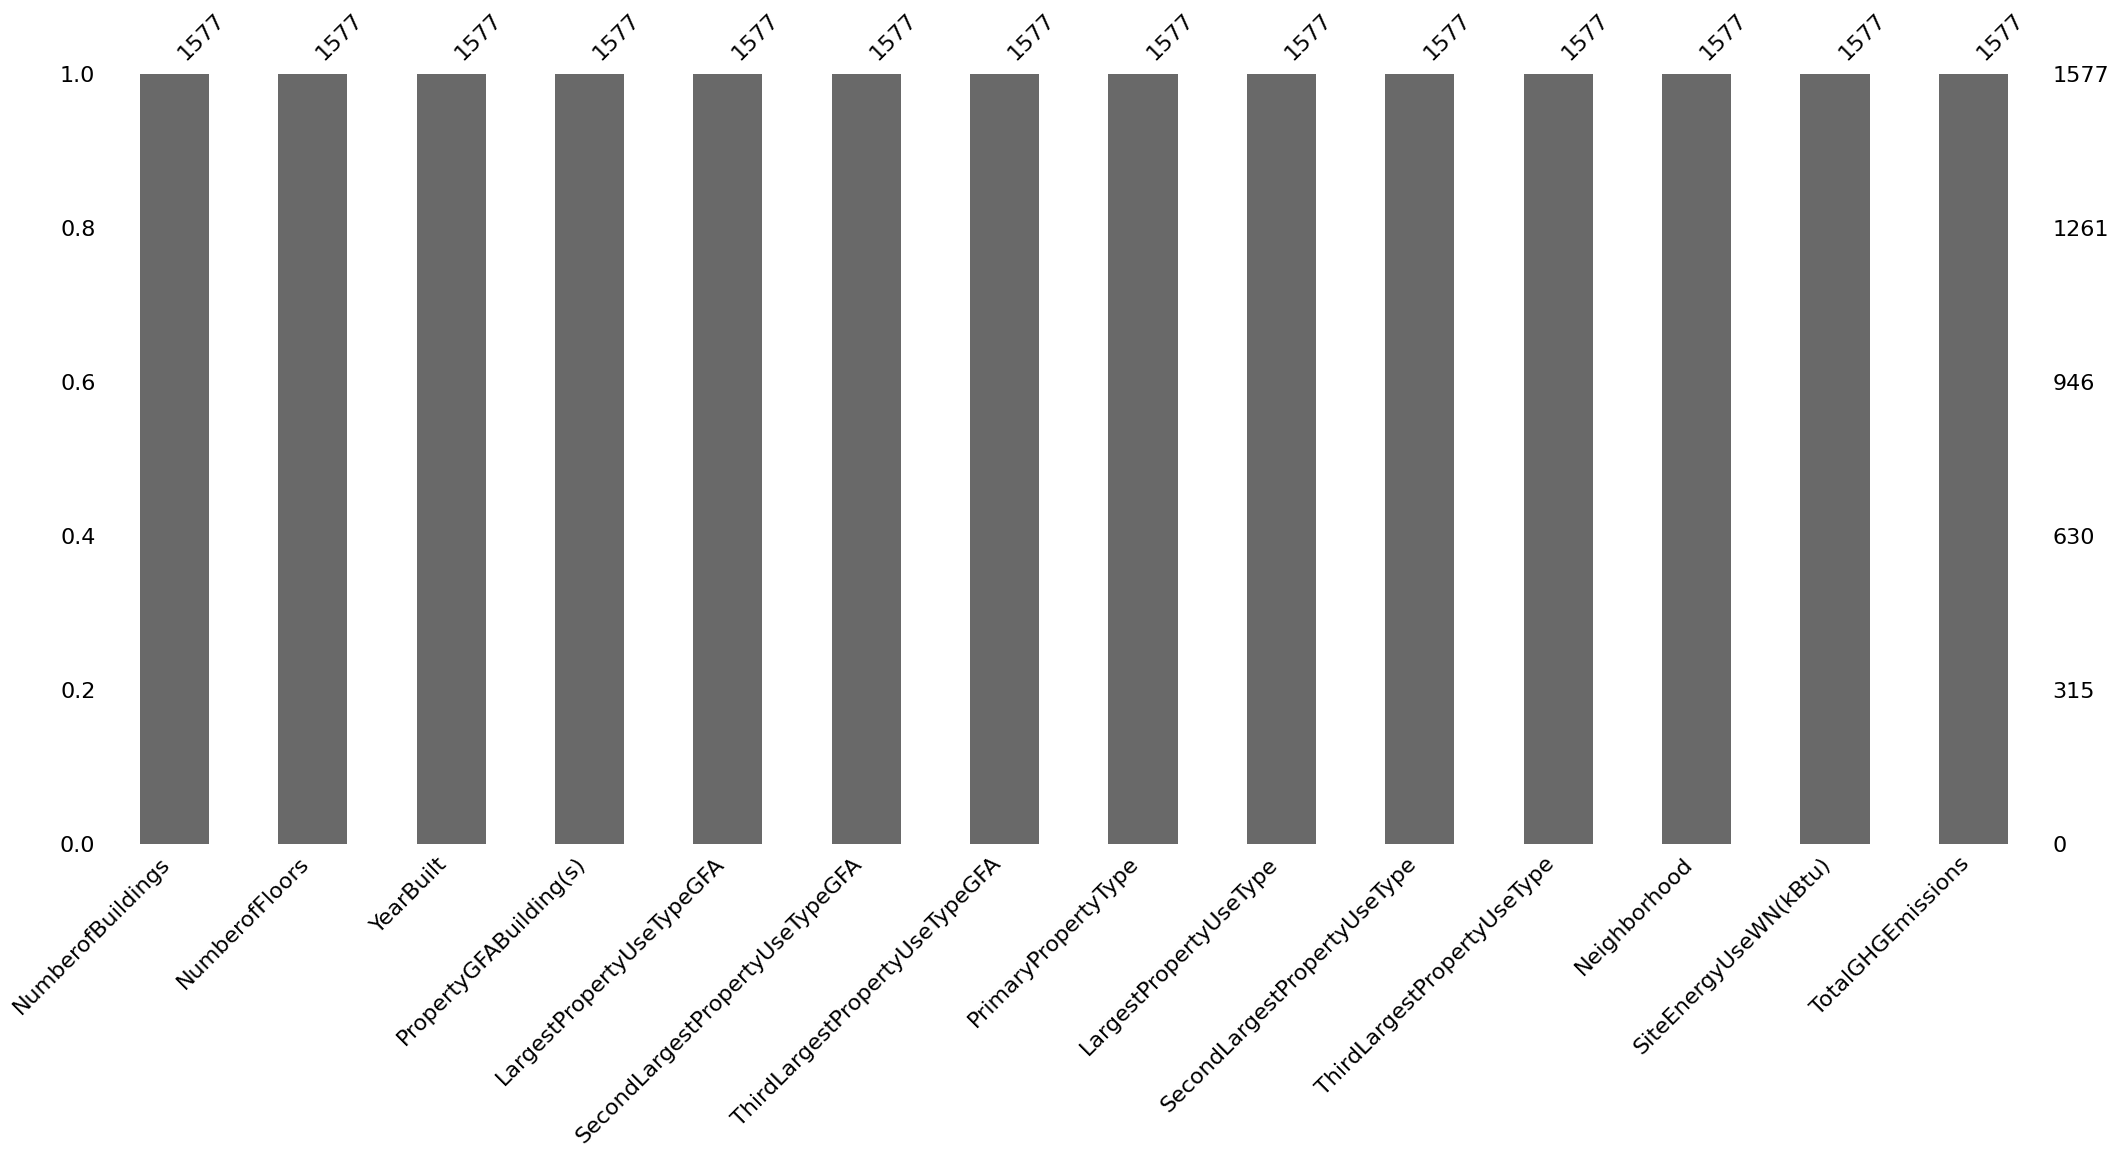

In [422]:
msno.bar(data_selected)

## Séparation des données en train et test

In [423]:
X = data_selected.iloc[:,0:-2] #On enlève l'émission de gaz à effet de serre et la variable cible. 
y = data_selected['SiteEnergyUseWN(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [424]:
num_var = ['NumberofBuildings','NumberofFloors','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']
cat_var = ['LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType', 'Neighborhood']

In [425]:
y.describe()

count    1.577000e+03
mean     8.333503e+06
std      2.256324e+07
min      5.811420e+04
25%      1.356948e+06
50%      2.778833e+06
75%      7.419337e+06
max      4.716139e+08
Name: SiteEnergyUseWN(kBtu), dtype: float64

<Axes: xlabel='SiteEnergyUseWN(kBtu)', ylabel='Count'>

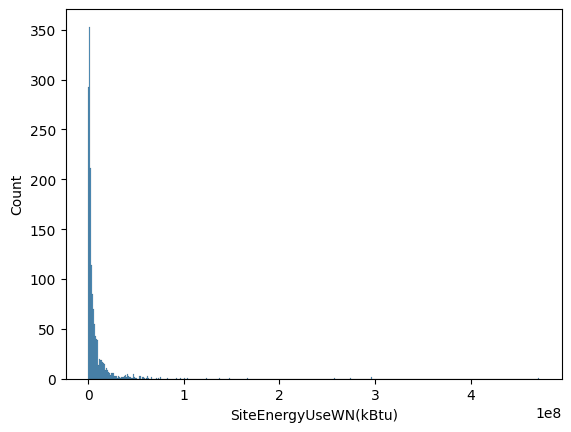

In [426]:
sns.histplot(y)

# III - Modélisation sur variables quantitatives seules

In [151]:
X_train_numeric = X_train[num_var]
X_test_numeric = X_test[num_var]

## Modèle dummy (baseline)

In [152]:
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 're

In [153]:
# Define pipeline
dummy_regressor = DummyRegressor()
pipe_dummy = make_pipeline(dummy_regressor)
print("RMSE moyen :", -np.round(np.mean(cross_val_score(pipe_dummy, X_train_numeric, y_train, cv = 5, 
                scoring = 'neg_root_mean_squared_error'))))

RMSE moyen : 18994739.0


In [154]:
y_train.mean()
y_test.mean()

np.float64(8231479.773201372)

np.float64(8740625.057414556)

- RMSE (Root Mean Squared Error) a la même unité que la variable cible et est très sensible aux outliers. Dépend de l'envergure de la variable cible et donc .... La valeur doit être minimisée
- MAE (mean absolute error) a la même unité que la variable cible et est moins sensible aux outliers que RMSE. Dépend de l'envergure de la variable cible et donc .... La valeur doit être minimisée
- R2 mesure l'éloignement par rapport à un modèle dummy : (1 - erreur_cumulée_modèle/erreur_cumulée_dummy)' La valeur doit être maximisée vers 1.

Il existe de nombreuses autres métriques pour la régression : https://scikit-learn.org/stable/api/sklearn.metrics.html#regression-metrics

## Modélisation linéaire

Le modèle de régression linéaire a besoin d'une normalisation des features au préalable. On commence par explorer les différents transformers associées à la normalisation :
- MinMaxScaler
- StandardScaler
- RobustScaler

### Test des scalers

Tester aussi le power transformer. Intéressant pour les variables très dissymétriques. Transfo avec logarithme un peu naif, power transfo est plus général qui contient une famille de tranfo type logarithme etc.. et choisit la plus adaptée à la donnée. Va réduire la squewness. 
Regarder la doc. 

array([[0.11111111, 0.13157895, 0.11603769, 0.08713252, 0.32973315,
        0.33957422],
       [0.03703704, 0.01315789, 0.01530302, 0.01843129, 0.        ,
        0.        ],
       [0.03703704, 0.01315789, 0.00789441, 0.00436876, 0.01494731,
        0.00352078],
       ...,
       [0.03703704, 0.05263158, 0.00645977, 0.00140316, 0.01811795,
        0.00689349],
       [0.03703704, 0.02631579, 0.01076188, 0.01261211, 0.        ,
        0.        ],
       [0.03703704, 0.02631579, 0.00940418, 0.01087231, 0.        ,
        0.        ]], shape=(1261, 6))

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

(0.0, 1.0)

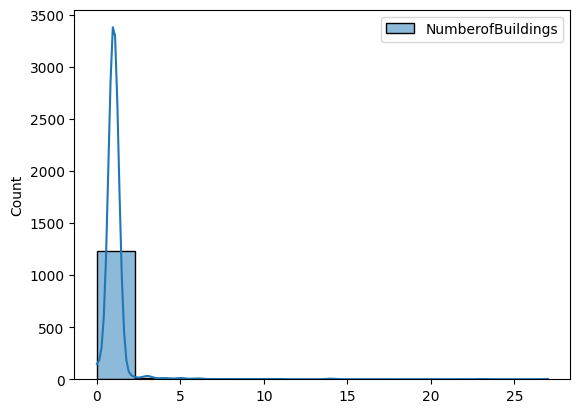

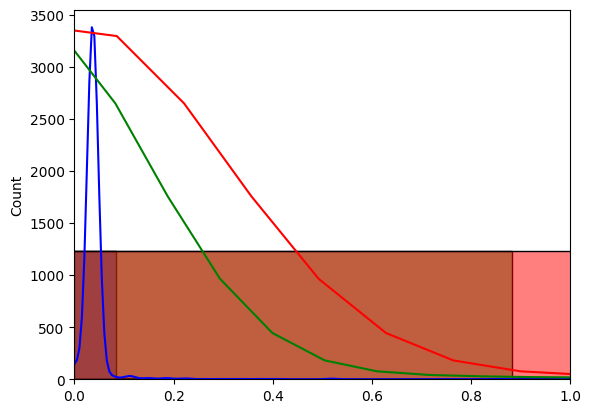

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

(0.0, 1.0)

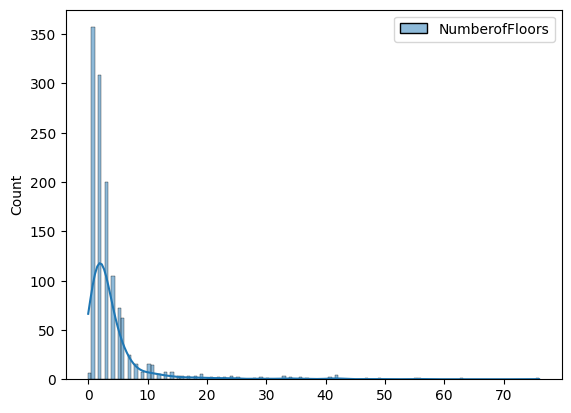

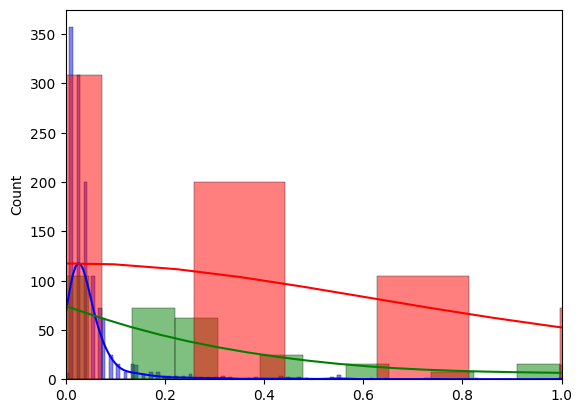

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

(0.0, 1.0)

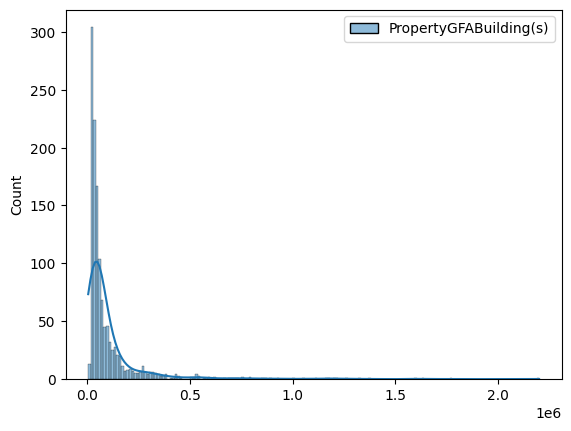

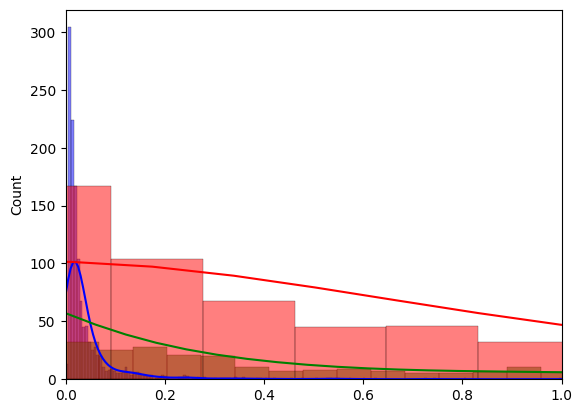

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

(0.0, 1.0)

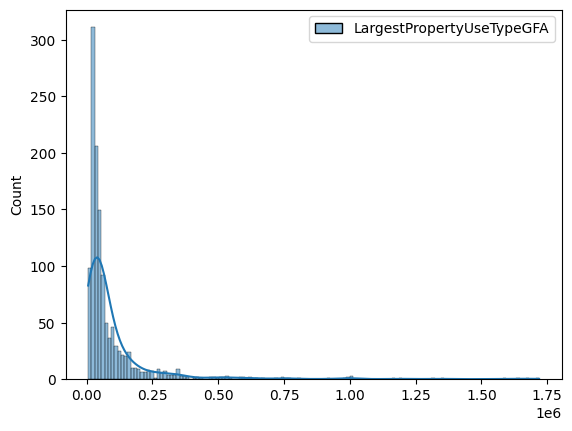

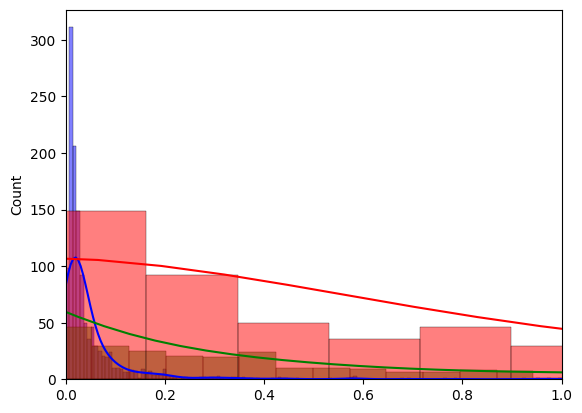

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

(0.0, 1.0)

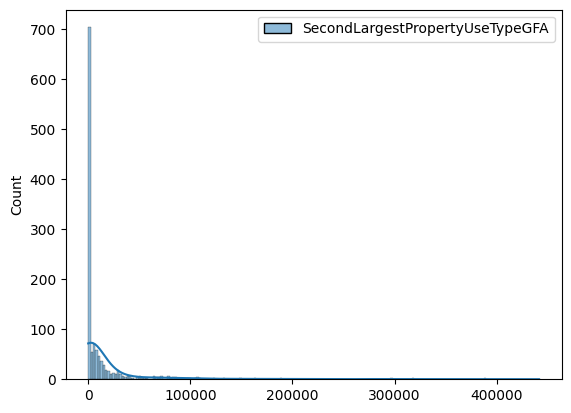

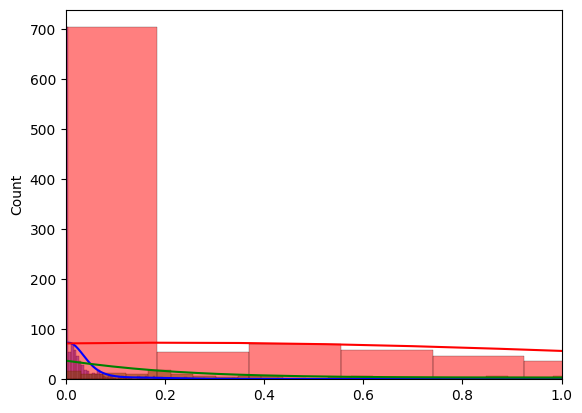

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

(0.0, 1.0)

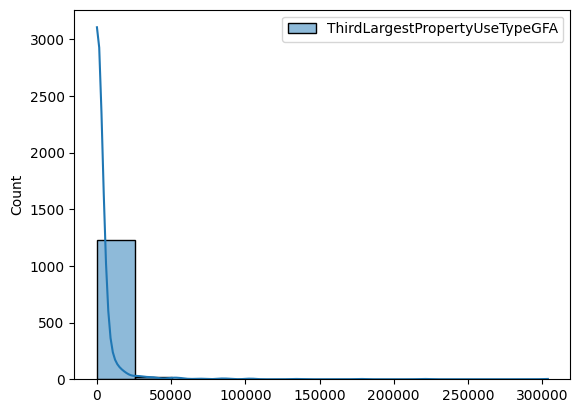

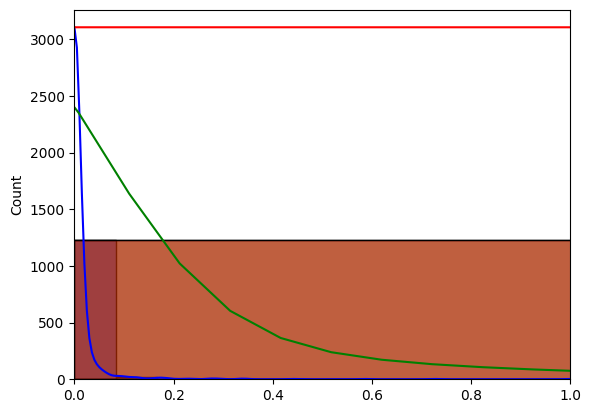

In [155]:
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X_train_numeric)
standard_scaler = StandardScaler()
X_standard = standard_scaler.fit_transform(X_train_numeric)
robust_scaler = RobustScaler()
X_robust = robust_scaler.fit_transform(X_train_numeric)


X_minmax

for idx, num_var in enumerate(X_train_numeric.columns): 
    plt.figure()
    sns.histplot(X_train_numeric[[num_var]], kde = True, color = 'black', label = 'sans transformation', alpha = 0.5)
    plt.figure()
    sns.histplot(X_minmax[:,idx], kde = True, color = 'blue', label = 'minmax', alpha = 0.5)
    sns.histplot(X_standard[:,idx], kde = True, color = 'green', label = 'standard', alpha = 0.5)
    sns.histplot(X_robust[:,idx], kde = True, color = 'red', label = 'robust', alpha = 0.5)
    plt.xlim((0,1))
    plt.show()

### Régresseur classique

In [156]:
#définir le pipeline
scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
reg = LinearRegression()
model_LinReg = make_pipeline(scaler, reg)
model_LinReg

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [157]:
# evaluate pipeline with cross validation
print("RMSE moyen :", -np.round(np.mean(cross_val_score(model_LinReg, X_train_numeric, y_train, cv = 5, 
                scoring = 'neg_root_mean_squared_error'))))

RMSE moyen : 13724910.0


C'est un tout petit peu mieux que le dummy mais l'erreur a toujours un odg plus important que la valeur moyenne cible. 

### Régresseur linéaire avec pénalités : Elastic Net

Introduire une pénalité pour empecher que les coeffs ne soient trop grands car source d'erreurs dans le modèle. LASRI(l1) et RIDGE = 2 techniques de régularisation. l1 peut tuer des variables. Ces techniques ont un param de régularisation. Permet de réduire l'overfitting. Tradeoff : trouver le paramètre optimal --> GridSearch.
On peut passer directement à ElasticNet(proportion de lasso et ridge et param de régularisation) et Rifge et Lasso pour régler les pénalités.  

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Define pipeline with StandardScaler and Ridge regression
steps = [
    ('scaler', StandardScaler()),
    ('elastic_net', ElasticNet())
]

pipeline = Pipeline(steps)

# Define parameter grid for alpha values
param_grid = {
    'elastic_net__alpha': np.logspace()
    np.array(range(0, 10))/10,  
    'elastic_net__l1_ratio': np.array(range(0, 10))/10
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    return_train_score=True,
    cv=5,
    scoring='r2'
)

# Fit the grid search to your data
grid_search.fit(X_train_numeric, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}") 
results = pd.DataFrame(grid_search.cv_results_)
results = results[['rank_test_score','mean_train_score','std_train_score','mean_test_score','std_test_score','params']].sort_values(['rank_test_score'])
results.head()

/home/chateaux/.conda/envs/OC_P4/lib/python3.13/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/chateaux/.conda/envs/OC_P4/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/chateaux/.conda/envs/OC_P4/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.042e+16, tolerance: 3.858e+13 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('elastic_net', ElasticNet())]),
             param_grid={'elastic_net__alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'elastic_net__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             return_train_score=True, scoring='r2')

Best parameters: {'elastic_net__alpha': np.float64(0.9), 'elastic_net__l1_ratio': np.float64(0.2)}
Best score: 0.49227677431122496


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,params
92,1,0.514825,0.039505,0.492277,0.118093,"{'elastic_net__alpha': 0.9, 'elastic_net__l1_ratio': 0.2}"
81,2,0.514825,0.039505,0.492277,0.118093,"{'elastic_net__alpha': 0.8, 'elastic_net__l1_ratio': 0.1}"
70,3,0.516099,0.039733,0.492269,0.117629,"{'elastic_net__alpha': 0.7, 'elastic_net__l1_ratio': 0.0}"
82,4,0.519934,0.040442,0.492085,0.116429,"{'elastic_net__alpha': 0.8, 'elastic_net__l1_ratio': 0.2}"
80,5,0.509749,0.038631,0.492061,0.120180,"{'elastic_net__alpha': 0.8, 'elastic_net__l1_ratio': 0.0}"


Mettre echeles log pour les param. 

## Modèles à base d'arbres

### Random Forest

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define pipeline 
steps = [
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators = 250)) #arbres en parallèle donc le plus d'estimateurs, le mieux
]

pipeline = Pipeline(steps)

# Define parameter grid for alpha values
param_grid = {
    # 'rf__n_estimators': np.array(range(50,250,10)),  
    'rf__max_depth': np.array(range(3,15)),
    'rf__min_samples_leaf' : ,

}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    return_train_score=True,
    cv=5,
    scoring='r2'
)

# Fit the grid search to your data
grid_search.fit(X_train_numeric, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}") 
results = pd.DataFrame(grid_search.cv_results_)
results = results[['rank_test_score','mean_train_score','std_train_score','mean_test_score','std_test_score','params']].sort_values(['rank_test_score'])
results.head()

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf', RandomForestRegressor())]),
             param_grid={'rf__max_depth': array([3, 4, 5, 6]),
                         'rf__n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240])},
             return_train_score=True, scoring='r2')

Best parameters: {'rf__max_depth': np.int64(4), 'rf__n_estimators': np.int64(100)}
Best score: 0.4366304927354402


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,params
25,1,0.827570,0.016798,0.436630,0.164794,"{'rf__max_depth': 4, 'rf__n_estimators': 100}"
44,2,0.856438,0.010311,0.435487,0.175991,"{'rf__max_depth': 5, 'rf__n_estimators': 90}"
39,3,0.828097,0.013749,0.431815,0.161044,"{'rf__max_depth': 4, 'rf__n_estimators': 240}"
79,4,0.879498,0.010552,0.429630,0.187516,"{'rf__max_depth': 6, 'rf__n_estimators': 240}"
66,5,0.873814,0.014765,0.425232,0.202310,"{'rf__max_depth': 6, 'rf__n_estimators': 110}"


Attention a pas trop limiter la profondeur et permetre le none. 

### Gradient boosting regressor

Parmi les plus efficaces sur les données structurées. Variantes XGBoost et LightGBM

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define pipeline with StandardScaler and Ridge regression
steps = [
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingRegressor())
]

pipeline = Pipeline(steps)

# Define parameter grid for alpha values
param_grid = {
    'gb__n_estimators': np.array(range(5,200,10)), #arbres en séquentiel
    'gb__learning_rate': [0.01, 0.1, 0.2, 0.5],
    'gb__max_depth': np.array(range(3,10)), # revoir peut etre
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    return_train_score=True,
    cv=5,
    scoring='r2'
)

# Fit the grid search to your data
grid_search.fit(X_train_numeric, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}") 
results = pd.DataFrame(grid_search.cv_results_)
results = results[['rank_test_score','mean_train_score','std_train_score','mean_test_score','std_test_score','params']].sort_values(['rank_test_score'])
results.head()

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gb', GradientBoostingRegressor())]),
             param_grid={'gb__learning_rate': [0.01, 0.1, 0.2, 0.5],
                         'gb__max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                         'gb__n_estimators': array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
       135, 145, 155, 165, 175, 185, 195])},
             return_train_score=True, scoring='r2')

Best parameters: {'gb__learning_rate': 0.01, 'gb__max_depth': np.int64(3), 'gb__n_estimators': np.int64(185)}
Best score: 0.44169329401324064


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,params
18,1,0.842271,0.019135,0.441693,0.146156,"{'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__n_estimators': 185}"
19,2,0.849427,0.019021,0.438573,0.147118,"{'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__n_estimators': 195}"
17,3,0.833846,0.019426,0.435197,0.145102,"{'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__n_estimators': 175}"
16,4,0.823985,0.020455,0.430297,0.145986,"{'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__n_estimators': 165}"
15,5,0.812861,0.020928,0.430076,0.144034,"{'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__n_estimators': 155}"


### Server Vector Machine

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Define pipeline with StandardScaler and Ridge regression
steps = [
    ('scaler', StandardScaler()),
    ('svm', SVR())
]

pipeline = Pipeline(steps)

# Define parameter grid for alpha values
param_grid = {
    'svm__kernel': ['linear', 'rbf'], #rbf = noyau gaussien
    'svm__degree' : np.array(range(1,5)),
    'svm__gamma': ['scale', 1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
    'svm__C': [1, 10, 100, 1000, 10000], #à tester avec une échelle plus large. Plus il est petit plus la régularisation est forte. 
    # 'svm__epsilon': [0, 0.001, 0.1, 1, 10, 100]
    }

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    return_train_score=True,
    cv=5,
    scoring='r2'
)

# Fit the grid search to your data
grid_search.fit(X_train_numeric, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}") 
results = pd.DataFrame(grid_search.cv_results_)
results = results[['rank_test_score','mean_train_score','std_train_score','mean_test_score','std_test_score','params']].sort_values(['rank_test_score'])
results.head()

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVR())]),
             param_grid={'svm__C': [1, 10, 100, 1000, 10000],
                         'svm__degree': array([1, 2, 3, 4]),
                         'svm__gamma': ['scale', 0.0001, 0.001, 0.01, 0.1, 0.2,
                                        0.5, 0.6, 0.9],
                         'svm__kernel': ['linear', 'rbf']},
             return_train_score=True, scoring='r2')

Best parameters: {'svm__C': 10000, 'svm__degree': np.int64(1), 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best score: 0.3724508163300331


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,params
358,1,0.322718,0.018767,0.372451,0.137973,"{'svm__C': 10000, 'svm__degree': 4, 'svm__gamma': 0.9, 'svm__kernel': 'linear'}"
356,1,0.322718,0.018767,0.372451,0.137973,"{'svm__C': 10000, 'svm__degree': 4, 'svm__gamma': 0.6, 'svm__kernel': 'linear'}"
326,1,0.322718,0.018767,0.372451,0.137973,"{'svm__C': 10000, 'svm__degree': 3, 'svm__gamma': 0.0001, 'svm__kernel': 'linear'}"
324,1,0.322718,0.018767,0.372451,0.137973,"{'svm__C': 10000, 'svm__degree': 3, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}"
328,1,0.322718,0.018767,0.372451,0.137973,"{'svm__C': 10000, 'svm__degree': 3, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}"


# IV - Feature engineering

In [431]:
data_engineered = data_selected.copy()

## Déterminer l'âge du bâtiment

In [433]:
data_engineered['Age'] = 2016 - data_engineered['YearBuilt']
data_engineered.drop('YearBuilt', axis = 1, inplace = True)

## Encodage du type de propriété

In [ ]:
len(data_engineered['PrimaryPropertyType'].unique())

20

Il y a beaucoup de types de propriétés différents. Est-il possible de regrouper les propriétés dans des cases plus larges ? 

<Axes: xlabel='PrimaryPropertyType', ylabel='count'>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Small- and Mid-Sized Office'),
  Text(1, 0, 'Other'),
  Text(2, 0, 'Warehouse'),
  Text(3, 0, 'Large Office'),
  Text(4, 0, 'K-12 School'),
  Text(5, 0, 'Mixed Use Property'),
  Text(6, 0, 'Retail Store'),
  Text(7, 0, 'Hotel'),
  Text(8, 0, 'Worship Facility'),
  Text(9, 0, 'Distribution Center'),
  Text(10, 0, 'Medical Office'),
  Text(11, 0, 'Supermarket / Grocery Store'),
  Text(12, 0, 'Self-Storage Facility'),
  Text(13, 0, 'University'),
  Text(14, 0, 'Senior Care Community'),
  Text(15, 0, 'Refrigerated Warehouse'),
  Text(16, 0, 'Restaurant'),
  Text(17, 0, 'Hospital'),
  Text(18, 0, 'Laboratory'),
  Text(19, 0, 'Office')])

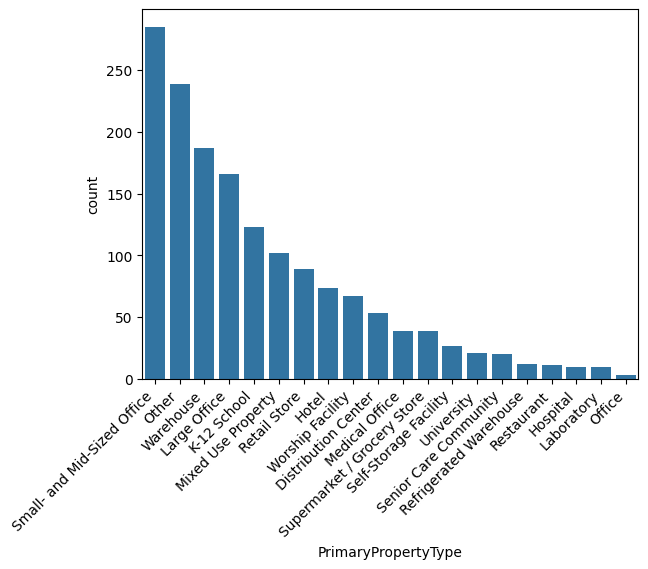

In [341]:
sns.barplot(data_engineered['PrimaryPropertyType'].value_counts())
plt.xticks(rotation = 45, ha = 'right')

Qu'il s'agisse d'un petit ou d'un grand bureau, le type d'utilisation (heures de présence notamment) est e même, et on a déjà les variables de surface pour rendre compte de la taille. On décide donc de regroupper tous les bureaux ensemble : 

In [342]:
# data_engineered.loc[(data_engineered['PrimaryPropertyType'] == 'Small- and Mid-Sized Office')|(data_engineered['PrimaryPropertyType'] == 'Large Office'),'PrimaryPropertyType'] = 'Office'

Même argument pour regrouper "Retail Store" et "Supermarket / Grocery Store" sous le label "Store"

In [343]:
# data_engineered.loc[(data_engineered['PrimaryPropertyType'] == 'Retail Store')|(data_engineered['PrimaryPropertyType'] == 'Supermarket / Grocery Store'),'PrimaryPropertyType'] = 'Store'

Meme argument pour regrouper 'Warehouse' et 'Self-Storage Facility' sous le label 'Storage'

In [344]:
# data_engineered.loc[(data_engineered['PrimaryPropertyType'] == 'Warehouse')|(data_engineered['PrimaryPropertyType'] == 'Self-Storage Facility'),'PrimaryPropertyType'] = 'Storage'

On pourrait regrouper 'Mixed Use Property' avec 'Other' sous le label 'Other' mais je préfère utiliser la colonne 'LargestPropertyUseType' pour classer les propriétés dans les bons types 

In [345]:
# enc = OneHotEncoder()
# enc.fit_transform(data_selected[['PrimaryPropertyType']]).toarray()
# len(enc.get_feature_names_out())

## Encodage de la variable 'Neighborhood' en binaire

One hot encoder marchera mieux que le binary sur un modèle linéaire et inversement. 

In [435]:
from category_encoders.binary import BinaryEncoder
encoder = BinaryEncoder()
Neighborhoood_bin = encoder.fit_transform(data_engineered.Neighborhood)
Neighborhoood_bin.shape
data_engineered.drop('Neighborhood', axis = 1, inplace = True)
data_engineered = pd.concat([data_engineered.reset_index(drop=True),Neighborhoood_bin.reset_index(drop=True)], axis=1)

(1577, 4)

In [436]:
data_engineered.head()

,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SiteEnergyUseWN(kBtu),TotalGHGEmissions,Age,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3
0,1.0,12,88434,88434.0,0.0,0.0,Hotel,Hotel,none,none,7456910.0,249.98,89,0,0,0,1
1,1.0,11,88502,83880.0,15064.0,4622.0,Hotel,Hotel,Parking,Restaurant,8664479.0,295.86,20,0,0,0,1
2,1.0,41,759392,756493.0,0.0,0.0,Hotel,Hotel,none,none,73937112.0,2089.28,47,0,0,0,1
3,1.0,10,61320,61320.0,0.0,0.0,Hotel,Hotel,none,none,6946800.5,286.43,90,0,0,0,1
4,1.0,18,113580,123445.0,68009.0,0.0,Hotel,Hotel,Parking,Swimming Pool,14656503.0,505.01,36,0,0,0,1


## Création d'une colonne de profil énergétique

Selon les usages et le 'PrimaryPropertyType' en premier lieu, on va classer les propriétés en différents profils de consommation énergétique / émission de GES: 
- 'Very High' regroupe les usines, les hopitaux et centres de soins ainsi que les data centers
- 'High' regroupe les galeries et supermarchés, les restaurants et les gares / aéroports, ainsi que les entrepots réfrigérés
- 'Moderate' regroupe les hotels, cinémas et théatres, les institutions finacières telles que les banques, les bureaux, les gentres de sport et d'éducation. 
- 'Low' regroupe les lieux de culte, les musées, les mairies et autres bureaux de services publics, les tribunaux et stations de polices, et les centres de stockage non réfrigérés. 

In [ ]:
df_test = data_engineered.copy()
df_test.loc[(df_test['PrimaryPropertyType'] == 'Other')|(df_test['PrimaryPropertyType'] == 'Mixed Use Property'),'PrimaryPropertyType'] = df_test['LargestPropertyUseType'] 

category_mapping = {
    # Very High Energy & Emission Intensity
    'Manufacturing/Industrial Plant': 'Very High',
    'Data Center': 'Very High',
    'Hospital': 'Very High',
    'Other/Specialty Hospital': 'Very High',

    # High Energy & Emission Intensity
    'Supermarket / Grocery Store': 'High',
    'Supermarket/Grocery Store': 'High',
    'Restaurant': 'High',
    'Other - Restaurant/Bar': 'High',
    'Food Service': 'High',
    'Refrigerated Warehouse': 'High',
    'Strip Mall': 'High',
    'Other - Mall': 'High',
    'Senior Care Community': 'High',
    'Performing Arts': 'High',
    'Movie Theater': 'High',
    'Lifestyle Center': 'High',
    'Urgent Care/Clinic/Other Outpatient': 'High',
    'Medical Office': 'High',
    'Prison/Incarceration': 'High',

    # Moderate Energy & Emission Intensity
    'Repair Services (Vehicle, Shoe, Locksmith, etc)' : 'Moderate',
    'Hotel': 'Moderate',
    'Large Office': 'Moderate',
    'Small- and Mid-Sized Office': 'Moderate',
    'Office': 'Moderate',
    'Financial Office': 'Moderate',
    'Bank Branch': 'Moderate',
    'University': 'Moderate',
    'K-12 School': 'Moderate',
    'Adult Education': 'Moderate',
    'Other - Education': 'Moderate',
    'Laboratory': 'Moderate',
    'Retail Store': 'Moderate',
    'Automobile Dealership': 'Moderate',
    'Social/Meeting Hall': 'Moderate',
    'Fitness Center/Health Club/Gym': 'Moderate',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'Moderate',

    # Low Energy & Emission Intensity
    'Warehouse': 'Low',
    'Non-Refrigerated Warehouse': 'Low',
    'Distribution Center': 'Low',
    'Self-Storage Facility': 'Low',
    'Library': 'Low',
    'Museum': 'Low',
    'Worship Facility': 'Low',
    'Fire Station': 'Low',
    'Police Station': 'Low',
    'Courthouse': 'Low',
    'Parking': 'Low',
    'Other - Public Services': 'Low',
    'Other - Utility': 'Low',
    'Other - Recreation': 'Low',
    'Other - Entertainment/Public Assembly': 'Low',
    'Other - Services': 'Low',
    'Other - Education': 'Low',
    'Pre-school/Daycare': 'Low',
    'Other': 'Low',
    'Other - Specialty': 'Low',
    'Other - Public Services': 'Low'
}

# Apply the mapping to create the new column
data_engineered['Intensity'] = df_test['PrimaryPropertyType'].map(category_mapping)

In [438]:
data_engineered['Intensity'].value_counts()

Intensity
Moderate     851
Low          549
High         152
Very High     25
Name: count, dtype: int64

In [ ]:
class PropertyUseTypeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categories_ = None  # Stockera les catégories uniques
    
    def fit(self, X, y=None):
        """Apprend les catégories uniques à partir des données."""
        self.categories_ = set(X['LargestPropertyUseType']).union(
            X['SecondLargestPropertyUseType'],
            X['ThirdLargestPropertyUseType']
        )
        self.categories_.discard(None)  # Supprime les valeurs None éventuelles
        return self  # Retourne l'objet pour le chaînage dans un pipeline

    def transform(self, X):
        """Transforme le DataFrame en encodant les types de propriétés en colonnes numériques."""
        X_transformed = X.copy()

        # Initialisation des nouvelles colonnes à 0
        for category in self.categories_:
            X_transformed[category] = (
                (X_transformed['LargestPropertyUseType'] == category) * X_transformed['LargestPropertyUseTypeGFA'] +
                (X_transformed['SecondLargestPropertyUseType'] == category) * X_transformed['SecondLargestPropertyUseTypeGFA'] +
                (X_transformed['ThirdLargestPropertyUseType'] == category) * X_transformed['ThirdLargestPropertyUseTypeGFA']
            )

        # Suppression des colonnes originales
        X_transformed.drop(columns=[
            'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
            'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'
        ], inplace=True)

        return X_transformed

In [439]:
#TODO tester modèles en regroupant high et very high dans une seule catégorie.

Attention à ce que la personne qui ajoute des nouvelles données puisse réappliquer les memes traitement. Pour ce faire, créer une classe du meme type que PropertyUseTypeEncoder

### Encodage de la variable

Il s'agit d'une variable catégorielle ordinale, donc on va remplacer low par 1, moderate par 2 etc...

In [440]:
from category_encoders.ordinal import OrdinalEncoder

mapping =[ {'col': 'Intensity',
	'mapping': {
            	np.nan: 0,
            	'Low': 1,
            	'Moderate': 2,
            	'High': 3,
            	'Very High': 4
            	}
        	} ]

encoder = OrdinalEncoder(mapping=mapping)
intensity = encoder.fit_transform(data_engineered.Intensity)
intensity.value_counts(dropna = False)
data_engineered['Intensity'] = intensity.copy()

Intensity
2            851
1            549
3            152
4             25
Name: count, dtype: int64

## Encodage des colonnes d'usage en colonnes numériques pondérées par les surfaces associées

In [441]:
Use_type = pd.concat([data_engineered['LargestPropertyUseType'],data_engineered['SecondLargestPropertyUseType'],data_engineered['ThirdLargestPropertyUseType']],axis = 0)
len(Use_type.unique())

63

In [442]:
class PropertyUseTypeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categories_ = None  # Stockera les catégories uniques
    
    def fit(self, X, y=None):
        """Apprend les catégories uniques à partir des données."""
        self.categories_ = set(X['LargestPropertyUseType']).union(
            X['SecondLargestPropertyUseType'],
            X['ThirdLargestPropertyUseType']
        )
        self.categories_.discard(None)  # Supprime les valeurs None éventuelles
        return self  # Retourne l'objet pour le chaînage dans un pipeline

    def transform(self, X):
        """Transforme le DataFrame en encodant les types de propriétés en colonnes numériques."""
        X_transformed = X.copy()

        # Initialisation des nouvelles colonnes à 0
        for category in self.categories_:
            X_transformed[category] = (
                (X_transformed['LargestPropertyUseType'] == category) * X_transformed['LargestPropertyUseTypeGFA'] +
                (X_transformed['SecondLargestPropertyUseType'] == category) * X_transformed['SecondLargestPropertyUseTypeGFA'] +
                (X_transformed['ThirdLargestPropertyUseType'] == category) * X_transformed['ThirdLargestPropertyUseTypeGFA']
            )

        # Suppression des colonnes originales
        X_transformed.drop(columns=[
            'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
            'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'
        ], inplace=True)

        return X_transformed

In [443]:
use_type_encoder = PropertyUseTypeEncoder()
use_type_encoder.fit(data_engineered)
data_engineered = use_type_encoder.transform(data_engineered)
data_engineered

PropertyUseTypeEncoder()

,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PrimaryPropertyType,SiteEnergyUseWN(kBtu),TotalGHGEmissions,Age,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Intensity,Other - Public Services,Enclosed Mall,Library,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Financial Office,Hotel,Automobile Dealership,Supermarket/Grocery Store,Retail Store,Food Sales,Other - Entertainment/Public Assembly,Other - Mall,Courthouse,Movie Theater,Social/Meeting Hall,Strip Mall,Vocational School,Swimming Pool,Prison/Incarceration,Other - Technology/Science,College/University,Adult Education,Senior Care Community,Food Service,Distribution Center,Fire Station,Bank Branch,Other/Specialty Hospital,Self-Storage Facility,Other - Restaurant/Bar,Pre-school/Daycare,Bar/Nightclub,Hospital (General Medical & Surgical),Data Center,Residence Hall/Dormitory,Other - Services,Parking,Museum,Other,Other - Recreation,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Manufacturing/Industrial Plant,Restaurant,Wholesale Club/Supercenter,Laboratory,Multifamily Housing,Worship Facility,Refrigerated Warehouse,Other - Utility,Other - Lodging/Residential,Lifestyle Center,Urgent Care/Clinic/Other Outpatient,Convenience Store without Gas Station,Other - Education,Non-Refrigerated Warehouse,Performing Arts,none,Fitness Center/Health Club/Gym,Medical Office,K-12 School,Office,Police Station,Fast Food Restaurant
0,1.0,12,88434,Hotel,7.456910e+06,249.98,89,0,0,0,1,2,0.0,0.0,0.0,0.0,0.0,88434.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,11,88502,Hotel,8.664479e+06,295.86,20,0,0,0,1,2,0.0,0.0,0.0,0.0,0.0,83880.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15064.0,0.0,0.0,0.0,0.0,0.0,4622.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,41,759392,Hotel,7.393711e+07,2089.28,47,0,0,0,1,2,0.0,0.0,0.0,0.0,0.0,756493.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,10,61320,Hotel,6.946800e+06,286.43,90,0,0,0,1,2,0.0,0.0,0.0,0.0,0.0,61320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,18,113580,Hotel,1.465650e+07,505.01,36,0,0,0,1,2,0.0,0.0,0.0,0.0,0.0,123445.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572,1.0,1,12294,Office,9.430032e+05,20.94,26,0,1,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12294.0,0.0,0.0
1573,1.0,1,16000,Other,1.053706e+06,32.17,12,0,0,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1574,1.0,1,13157,Other,6.053764e+06,223.54,42,1,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [444]:
data_engineered.drop(['none','PrimaryPropertyType'], axis = 1, inplace = True)

In [445]:
data_engineered.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)',
       'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'Age', 'Neighborhood_0',
       'Neighborhood_1', 'Neighborhood_2', 'Neighborhood_3', 'Intensity',
       'Other - Public Services', 'Enclosed Mall', 'Library',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Financial Office', 'Hotel', 'Automobile Dealership',
       'Supermarket/Grocery Store', 'Retail Store', 'Food Sales',
       'Other - Entertainment/Public Assembly', 'Other - Mall', 'Courthouse',
       'Movie Theater', 'Social/Meeting Hall', 'Strip Mall',
       'Vocational School', 'Swimming Pool', 'Prison/Incarceration',
       'Other - Technology/Science', 'College/University', 'Adult Education',
       'Senior Care Community', 'Food Service', 'Distribution Center',
       'Fire Station', 'Bank Branch', 'Other/Specialty Hospital',
       'Self-Storage Facility', 'Other - Restaurant/Bar', 'Pre-school/Daycare',
       'Bar/Nightclub

Inclure dans un pipeline

## Création et exécution du pipeline de preprocessing

In [357]:
# property_usage_cols = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType','LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']
# pipe_property_type = Pipeline([
#     ('property_type_encoder', OneHotEncoder())
# ])
# pipe_property_usage = Pipeline([
#     ('property_usage_encoder', PropertyUseTypeEncoder())
# ])
# cat_col_transformer = ColumnTransformer(transformers = [
#     ('pipe_property_type', pipe_property_type, ['PrimaryPropertyType']),
#     ('pipe_property_usage', pipe_property_usage, property_usage_cols)
# ],
#     remainder='passthrough',
#     n_jobs = -1
# )
# scaler = StandardScaler()
# preprocessing_pipeline = make_pipeline(cat_col_transformer,scaler)

In [358]:
# preprocessing_pipeline.fit_transform(X_train,y_train)

# V - Modélisation après feature engineering

### Séparation des données en testset et train set

In [446]:
data_engineered.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)',
       'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'Age', 'Neighborhood_0',
       'Neighborhood_1', 'Neighborhood_2', 'Neighborhood_3', 'Intensity',
       'Other - Public Services', 'Enclosed Mall', 'Library',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Financial Office', 'Hotel', 'Automobile Dealership',
       'Supermarket/Grocery Store', 'Retail Store', 'Food Sales',
       'Other - Entertainment/Public Assembly', 'Other - Mall', 'Courthouse',
       'Movie Theater', 'Social/Meeting Hall', 'Strip Mall',
       'Vocational School', 'Swimming Pool', 'Prison/Incarceration',
       'Other - Technology/Science', 'College/University', 'Adult Education',
       'Senior Care Community', 'Food Service', 'Distribution Center',
       'Fire Station', 'Bank Branch', 'Other/Specialty Hospital',
       'Self-Storage Facility', 'Other - Restaurant/Bar', 'Pre-school/Daycare',
       'Bar/Nightclub

In [458]:
X = data_engineered.drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'], axis = 1) #On enlève l'émission de gaz à effet de serre et la variable cible.
# X =  data_engineered[['NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)','Age', 'Intensity', 'Neighborhood_0',
       # 'Neighborhood_1', 'Neighborhood_2', 'Neighborhood_3']]
y = data_engineered['SiteEnergyUseWN(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Modélisation linéaire

Le modèle de régression linéaire a besoin d'une normalisation des features au préalable. On commence par explorer les différents transformers associées à la normalisation :
- MinMaxScaler
- StandardScaler
- RobustScaler

### Régresseur classique

In [448]:
#définir le pipeline
scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_train)
reg = LinearRegression()
model_LinReg = make_pipeline(scaler, reg)
model_LinReg

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('linearregression', LinearRegression())])

In [449]:
# evaluate pipeline with cross validation
print("r2 moyen :", -np.round(np.mean(cross_val_score(model_LinReg, X_train, y_train, cv = 5, 
                scoring = 'r2'))))

r2 moyen : -0.0


C'est un tout petit peu mieux que le dummy mais l'erreur a toujours un odg plus important que la valeur moyenne cible. 

### Régresseur linéaire avec pénalités : Elastic Net

Introduire une pénalité pour empecher que les coeffs ne soient trop grands car source d'erreurs dans le modèle. LASRI(l1) et RIDGE = 2 techniques de régularisation. l1 peut tuer des variables. Ces techniques ont un param de régularisation. Permet de réduire l'overfitting. Tradeoff : trouver le paramètre optimal --> GridSearch.
On peut passer directement à ElasticNet(proportion de lasso et ridge et param de régularisation) et Rifge et Lasso pour régler les pénalités.  

In [462]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Define pipeline with StandardScaler and Ridge regression
steps = [
    ('scaler', RobustScaler()),
    ('elastic_net', ElasticNet())
]

pipeline = Pipeline(steps)

# Define parameter grid for alpha values
param_grid = {
    'elastic_net__alpha': np.array(range(0, 10))/10,  
    'elastic_net__l1_ratio': np.array(range(0, 10))/10
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    return_train_score=True,
    cv=5,
    scoring='r2'
)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}") 
results = pd.DataFrame(grid_search.cv_results_)
results = results[['rank_test_score','mean_train_score','std_train_score','mean_test_score','std_test_score','params']].sort_values(['rank_test_score'])
results.head()

/home/chateaux/.conda/envs/OC_P4/lib/python3.13/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/chateaux/.conda/envs/OC_P4/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/chateaux/.conda/envs/OC_P4/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e+16, tolerance: 3.858e+13 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('elastic_net', ElasticNet())]),
             param_grid={'elastic_net__alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'elastic_net__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             return_train_score=True, scoring='r2')

Best parameters: {'elastic_net__alpha': np.float64(0.9), 'elastic_net__l1_ratio': np.float64(0.0)}
Best score: 0.787096012012089


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,params
90,1,0.920672,0.008462,0.787096,0.082136,"{'elastic_net__alpha': 0.9, 'elastic_net__l1_ratio': 0.0}"
91,2,0.920750,0.008479,0.786744,0.082459,"{'elastic_net__alpha': 0.9, 'elastic_net__l1_ratio': 0.1}"
80,3,0.920759,0.008481,0.786701,0.082498,"{'elastic_net__alpha': 0.8, 'elastic_net__l1_ratio': 0.0}"
92,4,0.920829,0.008497,0.786333,0.082829,"{'elastic_net__alpha': 0.9, 'elastic_net__l1_ratio': 0.2}"
81,5,0.920829,0.008497,0.786333,0.082829,"{'elastic_net__alpha': 0.8, 'elastic_net__l1_ratio': 0.1}"


## Modèles à base d'arbres

### Random Forest

In [463]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define pipeline 
steps = [
    ('scaler', RobustScaler()),
    ('rf', RandomForestRegressor())
]

pipeline = Pipeline(steps)

# Define parameter grid for alpha values
param_grid = {
    'rf__n_estimators': np.array(range(50,250,10)),  
    'rf__max_depth': np.array(range(3,7))
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    return_train_score=True,
    cv=5,
    scoring='r2'
)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}") 
results = pd.DataFrame(grid_search.cv_results_)
results = results[['rank_test_score','mean_train_score','std_train_score','mean_test_score','std_test_score','params']].sort_values(['rank_test_score'])
results.head()

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('rf', RandomForestRegressor())]),
             param_grid={'rf__max_depth': array([3, 4, 5, 6]),
                         'rf__n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200, 210, 220, 230, 240])},
             return_train_score=True, scoring='r2')

Best parameters: {'rf__max_depth': np.int64(6), 'rf__n_estimators': np.int64(80)}
Best score: 0.6742307146928181


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,params
63,1,0.918047,0.017001,0.674231,0.174828,"{'rf__max_depth': 6, 'rf__n_estimators': 80}"
75,2,0.918801,0.014251,0.671401,0.168132,"{'rf__max_depth': 6, 'rf__n_estimators': 200}"
62,3,0.919306,0.011272,0.669180,0.169070,"{'rf__max_depth': 6, 'rf__n_estimators': 70}"
76,4,0.920436,0.014224,0.668232,0.161079,"{'rf__max_depth': 6, 'rf__n_estimators': 210}"
74,5,0.920483,0.012668,0.667569,0.163508,"{'rf__max_depth': 6, 'rf__n_estimators': 190}"


### Gradient boosting regressor

In [464]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define pipeline with StandardScaler and Ridge regression
steps = [
    ('scaler', RobustScaler()),
    ('gb', GradientBoostingRegressor())
]

pipeline = Pipeline(steps)

# Define parameter grid for alpha values
param_grid = {
    'gb__n_estimators': np.array(range(5,200,10)),
    'gb__learning_rate': [0.01, 0.1, 0.2, 0.5],
    'gb__max_depth': np.array(range(3,10)),
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    return_train_score=True,
    cv=5,
    scoring='r2'
)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}") 
results = pd.DataFrame(grid_search.cv_results_)
results = results[['rank_test_score','mean_train_score','std_train_score','mean_test_score','std_test_score','params']].sort_values(['rank_test_score'])
results.head()

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('gb', GradientBoostingRegressor())]),
             param_grid={'gb__learning_rate': [0.01, 0.1, 0.2, 0.5],
                         'gb__max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                         'gb__n_estimators': array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
       135, 145, 155, 165, 175, 185, 195])},
             return_train_score=True, scoring='r2')

Best parameters: {'gb__learning_rate': 0.5, 'gb__max_depth': np.int64(4), 'gb__n_estimators': np.int64(35)}
Best score: 0.6625752833707421


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,params
443,1,0.990448,0.002330,0.662575,0.151282,"{'gb__learning_rate': 0.5, 'gb__max_depth': 4, 'gb__n_estimators': 35}"
444,2,0.994032,0.001359,0.652014,0.151577,"{'gb__learning_rate': 0.5, 'gb__max_depth': 4, 'gb__n_estimators': 45}"
442,3,0.987329,0.002839,0.648089,0.156317,"{'gb__learning_rate': 0.5, 'gb__max_depth': 4, 'gb__n_estimators': 25}"
451,4,0.999021,0.000182,0.646994,0.147910,"{'gb__learning_rate': 0.5, 'gb__max_depth': 4, 'gb__n_estimators': 115}"
445,5,0.995717,0.000907,0.644141,0.151617,"{'gb__learning_rate': 0.5, 'gb__max_depth': 4, 'gb__n_estimators': 55}"


### Server Vector Machine

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Define pipeline with StandardScaler and Ridge regression
steps = [
    ('scaler', RobustScaler()),
    ('svm', SVR())
]

pipeline = Pipeline(steps)

# Define parameter grid for alpha values
param_grid = {
    'svm__kernel': ['linear', 'rbf'], 
    'svm__degree' : np.array(range(1,5)),
    'svm__gamma': ['scale', 1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
    'svm__C': [1, 10, 100, 1000, 10000],
    # 'svm__epsilon': [0, 0.001, 0.1, 1, 10, 100]
    }

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    return_train_score=True,
    cv=5,
    scoring='r2'
)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}") 
results = pd.DataFrame(grid_search.cv_results_)
results = results[['rank_test_score','mean_train_score','std_train_score','mean_test_score','std_test_score','params']].sort_values(['rank_test_score'])
results.head()